In [2]:
import sys
sys.path.append('eucalc_directory')
import eucalc
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from numpy import genfromtxt
from sklearn.decomposition import PCA

# Path to the folder containing the CSV files
datafolder = "to_share_w_helens_team"

all_files = os.listdir(datafolder)

# Get all CSV filenames in the folder
names = [file for file in all_files if file.lower().endswith(('.tif', '.tiff'))]


# Split names into K8 and K14 groups
names_k8 = [nm for nm in names if 'K8' in nm]
names_k14 = [nm for nm in names if 'K14' in nm]

## k8 vs k14 classification

In [3]:


import os
import tifffile as tiff
import eucalc as ec
import matplotlib.colors as mcolors
from PIL import Image
class EctImg:
    def __init__(self, nm, img, k=20, xinterval=(-1., 1.), xpoints=100, yinterval=(-1., 1.), ypoints=100, factor=3):
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints = xpoints
        self.ypoints = ypoints
        self.image = self.compute(img, k, xinterval, xpoints, yinterval, ypoints, factor)
        self.nm = nm
    def compute(self, img, k, xinterval, xpoints, yinterval, ypoints, factor):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.linspace(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]

        image = np.zeros((ypoints, xpoints), dtype=float)
        yvalues = np.linspace(yinterval[0], yinterval[1], ypoints+1, endpoint=True)
        for i in range(xpoints):
            column = ect1[:, i]
            for j in range(ypoints):
                value = 0
                if j < ypoints-1:
                    value = len(np.where((yvalues[j] <= column) & (column < yvalues[j+1]))[0])/k
                else:
                    value = len(np.where((yvalues[j] <= column) & (column <= yvalues[j+1]))[0])/k
                image[j, i] = value
        return image
    
    def plot(self):
        plt.figure(figsize=(10, 8))
        # Using xinterval and yinterval directly in extent
        plt.imshow(self.image, aspect='auto', extent=[self.xinterval[0], self.xinterval[1], self.yinterval[0], self.yinterval[1]], origin='lower', interpolation='none')
        plt.colorbar(label='Density')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('ECT Image Plot for '+ self.nm)
        plt.show()


def compute_ExIm(names, datafolder, k=480, xinterval=(-1, 1), xpoints=200, yinterval=(-450., 50.), ypoints=500, factor=3):
    ExImage = []
    
    for nm in names: 
        file_path = os.path.join(datafolder, nm)
        with Image.open(file_path) as img:
            img_array = np.array(img)
        
        # Now, compute the ECT image using the new array
        ect = EctImg(nm, img_array, k, xinterval, xpoints, yinterval, ypoints, factor)
        exim = ect.compute(img_array, k, xinterval, xpoints, yinterval, ypoints, factor)
        ExImage.append(exim)

    return ExImage


def extract_age(name):
    return name.split('_')[0]

unique_ages = list(set(extract_age(name) for name in names))

# Create a color map based on unique ages
cmap = cm.get_cmap('viridis', len(unique_ages))
age_to_color = {age: cmap(i) for i, age in enumerate(unique_ages)}

exims = compute_ExIm(names, datafolder, k=480, xinterval=(-1, 1), xpoints=400, yinterval=(-450., 50.), ypoints=500, factor=3)
flattened_images = [image.flatten() for image in exims]




/var/folders/g0/hv3lcsr90h9b96cxhfthkg840000gp/T/ipykernel_14128/2982952405.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('viridis', len(unique_ages))


In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Extract ages from file names
def extract_type(name):
    return name.split('_')[1]  # Assuming age is the first part of the filename

types = [extract_type(name) for name in names]

# Step 2: Prepare the feature vectors (flattened images) and corresponding labels (ages)
X = np.array(flattened_images)
y = np.array(types)
for n in [100, 200,300, 500,1000]:
    # Step 3: Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=n, random_state=42)

    # Step 4: Perform cross-validation
    cv_scores = cross_val_score(rf_classifier, X, y, cv=10)  # 5-fold cross-validation

    # Step 5: Print the cross-validation scores
    print(f"Cross-validation scores: {cv_scores}")
    print(f"Mean cross-validation accuracy: {np.mean(cv_scores)}")

Cross-validation scores: [1.         0.9        1.         0.9        0.7        1.
 0.8        0.8        0.77777778 0.77777778]
Mean cross-validation accuracy: 0.8655555555555555
Cross-validation scores: [1.         0.9        1.         1.         0.8        1.
 0.8        0.8        0.77777778 0.77777778]
Mean cross-validation accuracy: 0.8855555555555558
Cross-validation scores: [1.         0.9        1.         1.         0.9        1.
 0.8        0.7        0.77777778 0.77777778]
Mean cross-validation accuracy: 0.8855555555555557
Cross-validation scores: [1.         0.9        1.         1.         0.9        1.
 0.8        0.7        0.77777778 0.77777778]
Mean cross-validation accuracy: 0.8855555555555557
Cross-validation scores: [1.         0.9        1.         1.         0.9        1.
 0.8        0.7        0.77777778 0.77777778]
Mean cross-validation accuracy: 0.8855555555555557


Processing type group: K14
mean Model training score: 0.8975


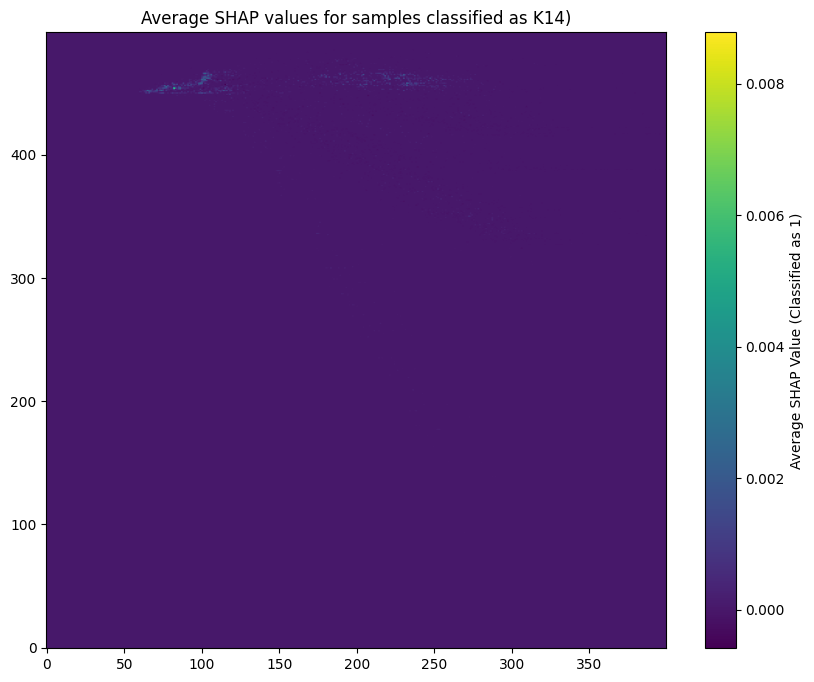

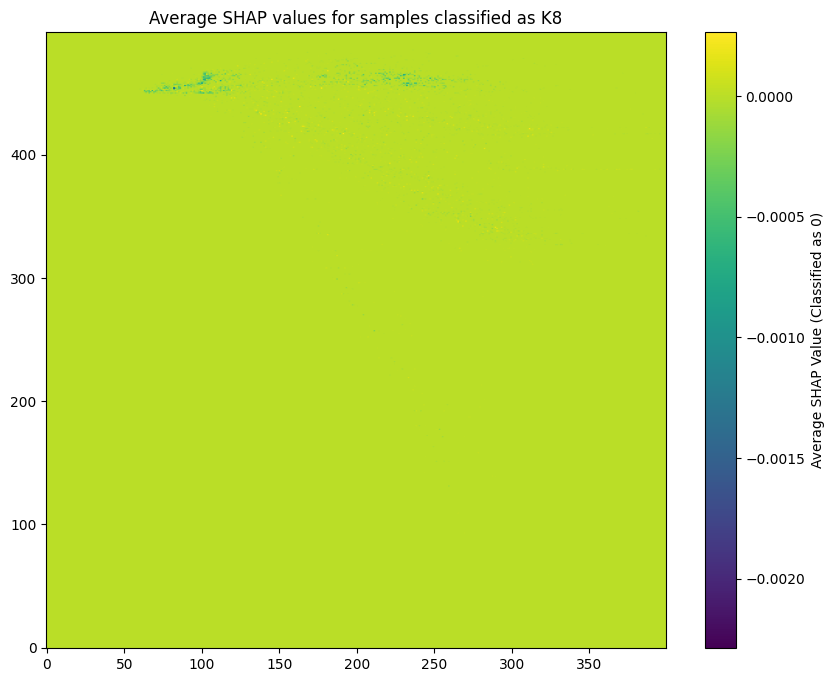

Processing type group: K8
mean Model training score: 0.8975


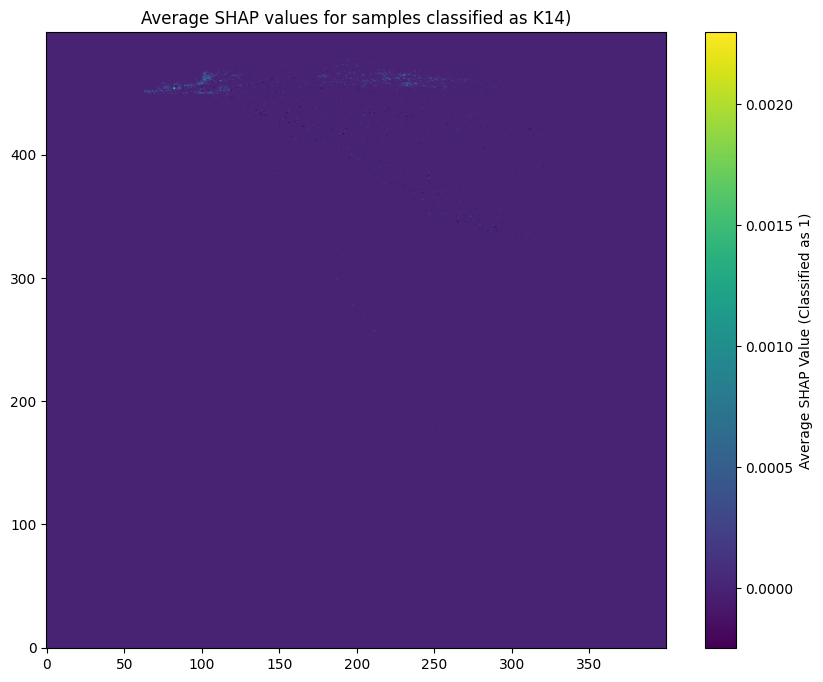

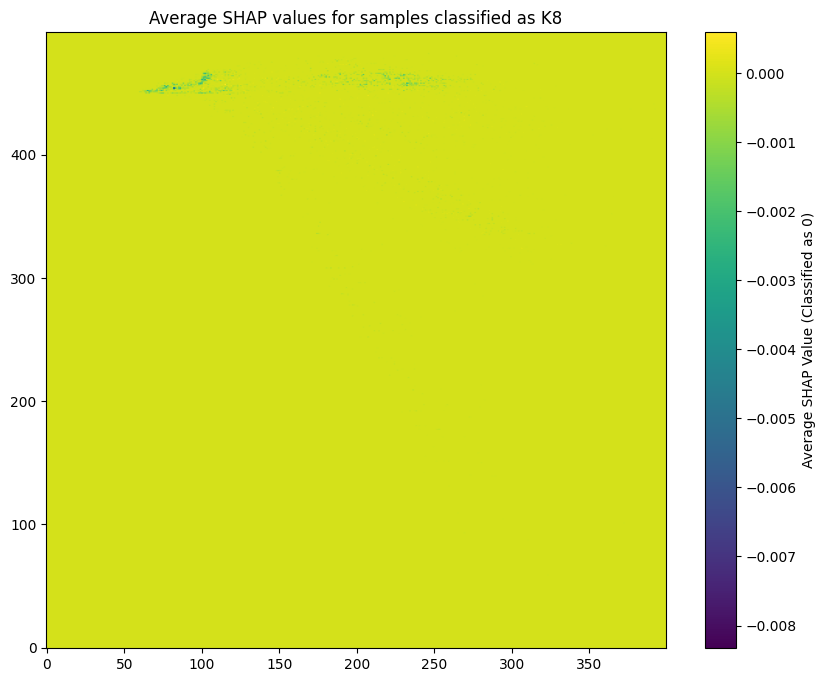

In [14]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Step 1: Extract ages from file names
def extract_type(name):
    return name.split('_')[1]  # Assuming age is the first part of the filename

# Assuming names_k8 and flattened_k8 are already defined
types = [extract_type(name) for name in names]
X = np.array(flattened_images)
y = np.array(types)
unique_ages = np.unique(y)  # Find unique ages in the dataset
ypoints, xpoints = 500, 400  # Set the appropriate image dimensions

# Number of trials for train-test splitting
num_trials = 20

# Loop over each unique age to create binary classification problems
for age in unique_ages:
    print(f"Processing type group: {age}")
    
    # Binary classification: 1 if the sample belongs to the current age, 0 otherwise
    binary_labels = np.where(y == age, 1, 0)
    
    # Prepare variables to store SHAP values for averaging
    shap_values_aggregate_1 = None  # To store the sum of SHAP values for class 1 across trials
    shap_values_aggregate_0 = None  # To store the sum of SHAP values for class 0 across trials
    n_1 = 0  # Counter for trials where samples are classified as 1
    n_0 = 0  # Counter for trials where samples are classified as 0
    score =[]
    # Loop for multiple random splits
    for trial in range(num_trials):
        # print(f"Trial {trial + 1}/{num_trials}")

        # Step 2: Randomize train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, binary_labels, test_size=0.2, random_state=40+trial)

        # Step 3: Initialize and train the Random Forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
        rf_classifier.fit(X_train, y_train)
        current_score = rf_classifier.score(X_test, y_test)
        score.append(rf_classifier.score(X_test, y_test))

        if current_score > 0.7:
            # Step 4: Initialize SHAP explainer and compute SHAP values
            explainer = shap.TreeExplainer(rf_classifier)
            shap_values = explainer.shap_values(X_test)

            # Step 5: Since this is binary classification, shap_values[1] gives SHAP for class 1
            shap_values_class = shap_values[:, :, 1]  # SHAP values for class "age"

            # Step 6: Get predicted classes
            y_pred = rf_classifier.predict(X_test)

            # Separate SHAP values for class 1 and class 0
            shap_values_1 = shap_values_class[y_pred == 1]  # Samples classified as 1
            shap_values_0 = shap_values_class[y_pred == 0]  # Samples classified as 0

            # Initialize aggregate storage for class 1 and class 0
            if shap_values_aggregate_1 is None:
                shap_values_aggregate_1 = np.zeros((ypoints, xpoints))
            if shap_values_aggregate_0 is None:
                shap_values_aggregate_0 = np.zeros((ypoints, xpoints))

            # Sum SHAP values for class 1
            if len(shap_values_1) > 0:
                shap_values_mean_1 = shap_values_1.mean(axis=0)  # Average over samples classified as 1
                shap_image_1 = shap_values_mean_1.reshape(ypoints, xpoints)
                shap_values_aggregate_1 += shap_image_1
                n_1 += 1

            # Sum SHAP values for class 0
            if len(shap_values_0) > 0:
                shap_values_mean_0 = shap_values_0.mean(axis=0)  # Average over samples classified as 0
                shap_image_0 = shap_values_mean_0.reshape(ypoints, xpoints)
                shap_values_aggregate_0 += shap_image_0
                n_0 += 1

    # Step 7: Average the SHAP values across all trials
    if n_1 > 0:
        shap_values_avg_1 = shap_values_aggregate_1 / n_1
    if n_0 > 0:
        shap_values_avg_0 = shap_values_aggregate_0 / n_0

    print(f"mean Model training score: {np.mean(score)}")
    # Step 8: Visualize the averaged SHAP values for class 1 (samples classified as 1)
    downsampled_importance_1 = block_reduce(shap_values_avg_1, block_size=(1, 1), func=np.mean)
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance_1, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value (Classified as 1)')
    plt.title(f"Average SHAP values for samples classified as K14)")
    plt.show()

    # Step 9: Visualize the averaged SHAP values for class 0 (samples classified as 0)
    downsampled_importance_0 = block_reduce(shap_values_avg_0, block_size=(1, 1), func=np.mean)
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance_0, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value (Classified as 0)')
    plt.title(f"Average SHAP values for samples classified as K8")
    plt.show()


Trial 1/20
Model training score: 0.6
Trial 2/20
Model training score: 0.8
Trial 3/20
Model training score: 1.0
Trial 4/20
Model training score: 0.8
Trial 5/20
Model training score: 1.0
Trial 6/20
Model training score: 0.9
Trial 7/20
Model training score: 0.8
Trial 8/20
Model training score: 1.0
Trial 9/20
Model training score: 0.9
Trial 10/20
Model training score: 0.8
Trial 11/20
Model training score: 0.9
Trial 12/20
Model training score: 0.9
Trial 13/20
Model training score: 1.0
Trial 14/20
Model training score: 0.9
Trial 15/20
Model training score: 0.8
Trial 16/20
Model training score: 0.9
Trial 17/20
Model training score: 1.0
Trial 18/20
Model training score: 1.0
Trial 19/20
Model training score: 1.0
Trial 20/20
Model training score: 1.0


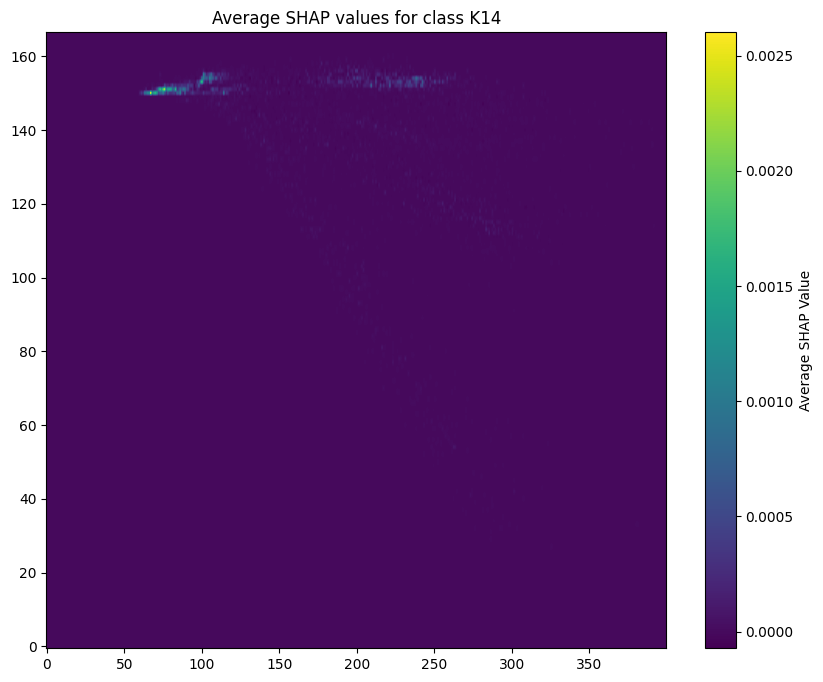

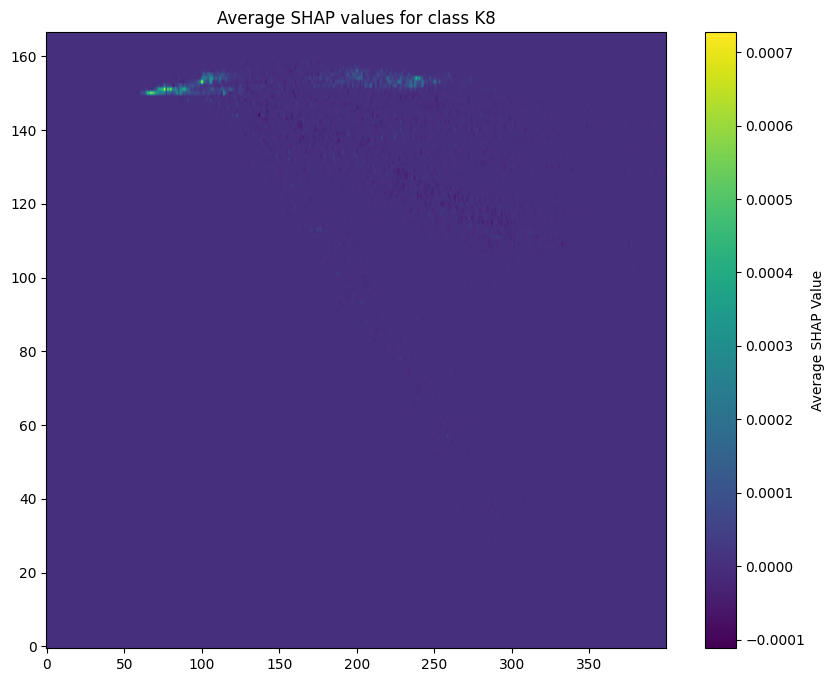

In [12]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Step 1: Extract ages from file names (as done before)
def extract_type(name):
    return name.split('_')[1]  # Assuming age is the first part of the filename

ypoints, xpoints = 500, 400
# Assuming names_k8 and flattened_k8 are already defined
class_order = rf_classifier.classes_
ages_k8 = [extract_type(name) for name in names]
X = np.array(flattened_images)
y = np.array(ages_k8)
# Number of trials for train-test splitting
num_trials = 20

# Prepare variables to store SHAP values for averaging
shap_values_aggregate = None  # To store the sum of SHAP values across trials
n=np.zeros(len(class_order)) # account for the number of trials with accuracy > 0.7
# Loop for multiple random splits
for trial in range(num_trials):
    print(f"Trial {trial + 1}/{num_trials}")

    # Step 2: Randomize train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40+trial)

    # Step 3: Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=40)
    rf_classifier.fit(X_train, y_train)
    print(f"Model training score: {rf_classifier.score(X_test, y_test)}")

    if rf_classifier.score(X_test, y_test) > 0.7:
        # Step 4: Initialize SHAP explainer and compute SHAP values
        explainer = shap.TreeExplainer(rf_classifier)
        shap_values = explainer.shap_values(X_test)

        # Step 5: Iterate through each class
        class_order = rf_classifier.classes_
        if shap_values_aggregate is None:
            # Initialize aggregate storage with the correct shape
            shap_values_aggregate = np.zeros((len(class_order), ypoints, xpoints))

        for k in range(len(class_order)):  # shap_values.shape[2] corresponds to number of classes
            shap_values_class = shap_values[:, :, k]  # SHAP values for class k
            class_index = np.where(y_test == class_order[k])[0]
            if class_index.size > 0:
                # Compute the mean SHAP values for this class in this trial
                chosen_shap_values = shap_values_class[class_index]
                shap_values_mean = chosen_shap_values.sum(axis=0)
                shap_image = shap_values_mean.reshape(ypoints, xpoints)

                # Sum SHAP values for averaging later
                shap_values_aggregate[k] += shap_image
                n[k]+=len(class_index)



# Step 7: Visualize the averaged SHAP values for each class
for k in range(len(class_order)):
    shap_image_avg = shap_values_aggregate[k]/n[k]

    # Optionally downsample the image for better visualization
    downsampled_importance = block_reduce(shap_image_avg, block_size=(3, 1), func=np.mean)

    # Plot the SHAP values as an image
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value')
    plt.title(f"Average SHAP values for class {class_order[k]}")
    plt.show()


## SHAP value of K8

In [2]:


import os
import tifffile as tiff
import eucalc as ec
import matplotlib.colors as mcolors
from PIL import Image
class EctImg:
    def __init__(self, nm, img, k=20, xinterval=(-1., 1.), xpoints=100, yinterval=(-1., 1.), ypoints=100, factor=3):
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints = xpoints
        self.ypoints = ypoints
        self.image = self.compute(img, k, xinterval, xpoints, yinterval, ypoints, factor)
        self.nm = nm
    def compute(self, img, k, xinterval, xpoints, yinterval, ypoints, factor):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.linspace(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]

        image = np.zeros((ypoints, xpoints), dtype=float)
        yvalues = np.linspace(yinterval[0], yinterval[1], ypoints+1, endpoint=True)
        for i in range(xpoints):
            column = ect1[:, i]
            for j in range(ypoints):
                value = 0
                if j < ypoints-1:
                    value = len(np.where((yvalues[j] <= column) & (column < yvalues[j+1]))[0])/k
                else:
                    value = len(np.where((yvalues[j] <= column) & (column <= yvalues[j+1]))[0])/k
                image[j, i] = value
        return image
    
    def plot(self):
        plt.figure(figsize=(10, 8))
        # Using xinterval and yinterval directly in extent
        plt.imshow(self.image, aspect='auto', extent=[self.xinterval[0], self.xinterval[1], self.yinterval[0], self.yinterval[1]], origin='lower', interpolation='none')
        plt.colorbar(label='Density')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('ECT Image Plot for '+ self.nm)
        plt.show()


def compute_ExIm(names, datafolder, k=480, xinterval=(-1, 1), xpoints=200, yinterval=(-450., 50.), ypoints=500, factor=3):
    ExImage = []
    
    for nm in names: 
        file_path = os.path.join(datafolder, nm)
        with Image.open(file_path) as img:
            img_array = np.array(img)
        
        # Now, compute the ECT image using the new array
        ect = EctImg(nm, img_array, k, xinterval, xpoints, yinterval, ypoints, factor)
        exim = ect.compute(img_array, k, xinterval, xpoints, yinterval, ypoints, factor)
        ExImage.append(exim)

    return ExImage


def extract_age(name):
    return name.split('_')[0]

unique_ages = list(set(extract_age(name) for name in names))

# Create a color map based on unique ages
cmap = cm.get_cmap('viridis', len(unique_ages))
age_to_color = {age: cmap(i) for i, age in enumerate(unique_ages)}

exim_k8 = compute_ExIm(names_k8, datafolder, k=480, xinterval=(-1, 1), xpoints=400, yinterval=(-450., 50.), ypoints=500, factor=3)
flattened_k8 = [image.flatten() for image in exim_k8]

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Extract ages from file names
def extract_age(name):
    return name.split('_')[0]  # Assuming age is the first part of the filename

ages_k8 = [extract_age(name) for name in names_k8]

# Step 2: Prepare the feature vectors (flattened images) and corresponding labels (ages)
X = np.array(flattened_k8)
y = np.array(ages_k8)

# Step 3: Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 4: Perform cross-validation
cv_scores = cross_val_score(rf_classifier, X, y, cv=5)  # 5-fold cross-validation

# Step 5: Print the cross-validation scores
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {np.mean(cv_scores)}")


Cross-validation scores: [0.71428571 0.85714286 0.64285714 0.64285714 0.85714286]
Mean cross-validation accuracy: 0.7428571428571429


Model training score: 0.7857142857142857
['Ad' 'E14' 'E16' 'NB' 'P7']
Indices for class Ad: [12]
Shape of chosen SHAP values for class Ad: (1, 200000)
(1, 200000)


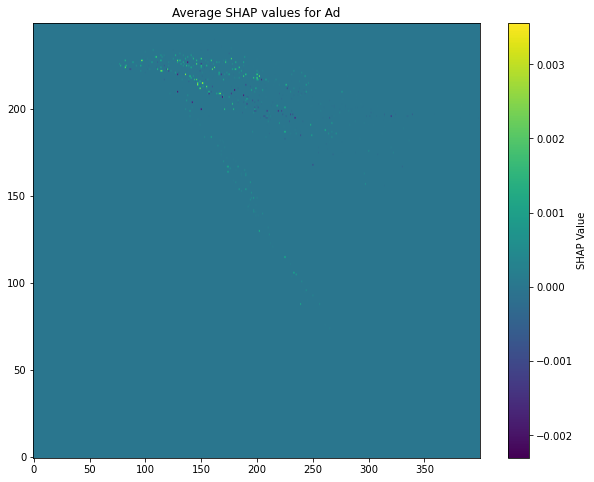

Indices for class E14: [ 0  7  8  9 11]
Shape of chosen SHAP values for class E14: (5, 200000)
(5, 200000)


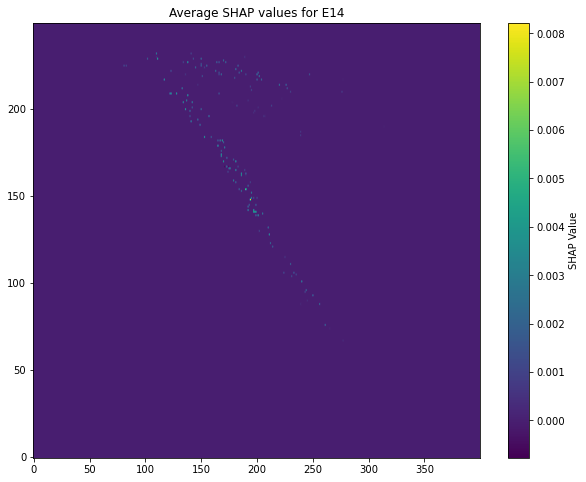

Indices for class E16: [ 4 10 13]
Shape of chosen SHAP values for class E16: (3, 200000)
(3, 200000)


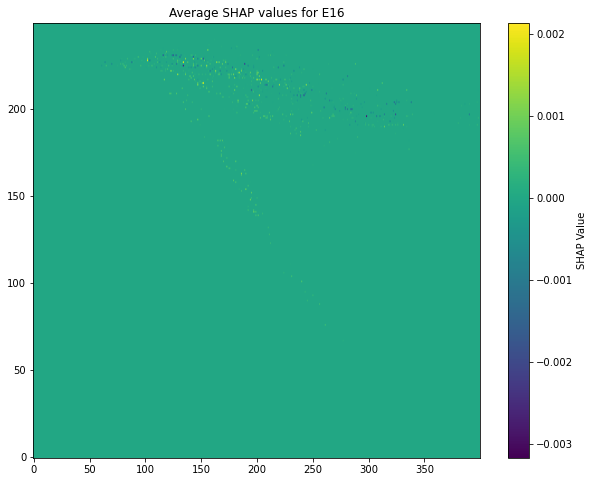

Indices for class NB: [1 2 5 6]
Shape of chosen SHAP values for class NB: (4, 200000)
(4, 200000)


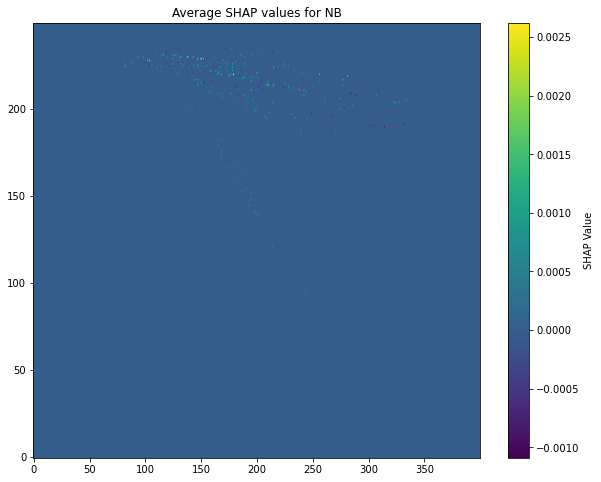

Indices for class P7: [3]
Shape of chosen SHAP values for class P7: (1, 200000)
(1, 200000)


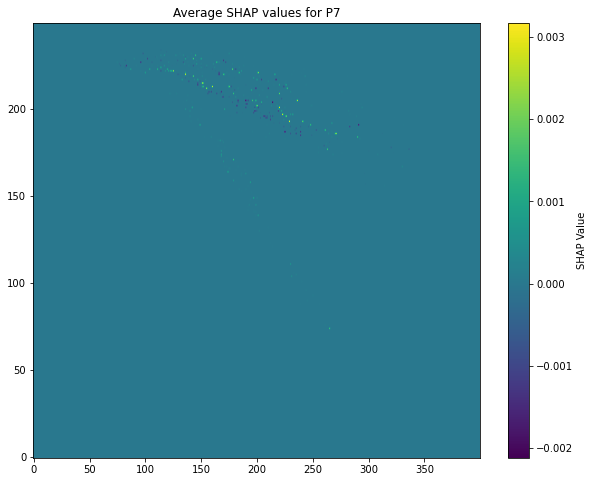

In [3]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Extract ages from file names (as done before)
def extract_age(name):
    return name.split('_')[0]  # Assuming age is the first part of the filename

ages_k8 = [extract_age(name) for name in names_k8]

# Step 2: Prepare the feature vectors (flattened images) and corresponding labels (ages)
X = np.array(flattened_k8)
y = np.array(ages_k8)
ypoints = 500
xpoints = 400
# Step 3: Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

# Step 5: Train the model
rf_classifier.fit(X_train, y_train)
print(f"Model training score: {rf_classifier.score(X_test, y_test)}")

# Step 6: Initialize the SHAP explainer
explainer = shap.TreeExplainer(rf_classifier)

# Step 7: Compute SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Step 8: Iterate through each unique class and compute SHAP values
unique_ages = list(set(extract_age(name) for name in names))

from skimage.measure import block_reduce
import matplotlib.pyplot as plt
class_order = rf_classifier.classes_
print(class_order)
for k in range(shap_values.shape[2]):
    shap_values_class = shap_values[:, :, k]
    class_index = np.where(y_test == class_order[k])[0]
    if class_index.size > 0:
        print(f"Indices for class {class_order[k]}:", class_index)
        chosen_shap_values = shap_values_class[class_index]
        print(f"Shape of chosen SHAP values for class {class_order[k]}: {chosen_shap_values.shape}")
        print(chosen_shap_values.shape)
        shap_values_mean = chosen_shap_values.mean(axis=0) 

        # Reshape the averaged SHAP values back to a 500x200 image
        shap_image = shap_values_mean.reshape(ypoints, xpoints)
        downsampled_importance = block_reduce(shap_image, block_size=(2, 1), func=np.mean)

        # Plot the SHAP values as an image
        plt.figure(figsize=(10, 8))
        plt.imshow(downsampled_importance, aspect='auto', origin='lower', cmap='viridis')
        plt.colorbar(label='SHAP Value')
        plt.title("Average SHAP values for "+ class_order[k])
        plt.show()


### multiple trials 

Trial 1/20
Model training score: 0.42857142857142855
Trial 2/20
Model training score: 0.7142857142857143
Trial 3/20
Model training score: 0.7142857142857143
Trial 4/20
Model training score: 0.7142857142857143
Trial 5/20
Model training score: 0.8571428571428571
Trial 6/20
Model training score: 0.8571428571428571
Trial 7/20
Model training score: 0.7142857142857143
Trial 8/20
Model training score: 1.0
Trial 9/20
Model training score: 0.7142857142857143
Trial 10/20
Model training score: 0.8571428571428571
Trial 11/20
Model training score: 0.5714285714285714
Trial 12/20
Model training score: 0.7142857142857143
Trial 13/20
Model training score: 0.7142857142857143
Trial 14/20
Model training score: 0.7142857142857143
Trial 15/20
Model training score: 0.7142857142857143
Trial 16/20
Model training score: 0.7142857142857143
Trial 17/20
Model training score: 0.5714285714285714
Trial 18/20
Model training score: 1.0
Trial 19/20
Model training score: 0.8571428571428571
Trial 20/20
Model training scor

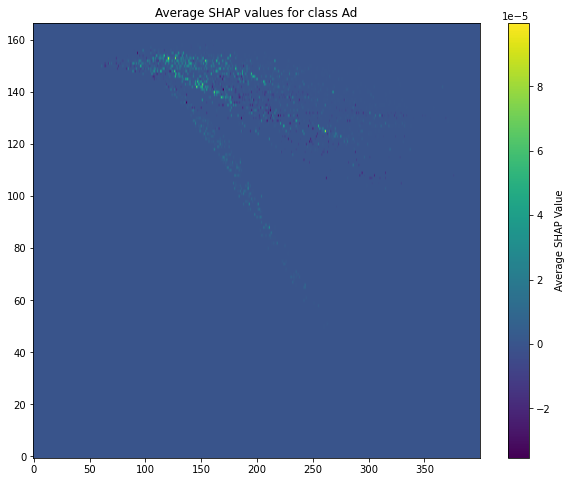

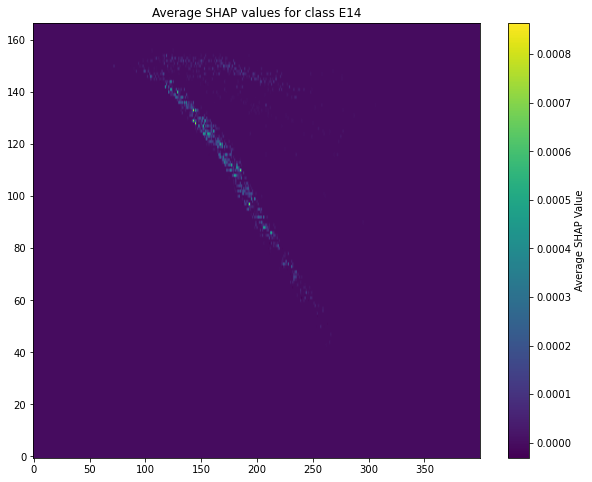

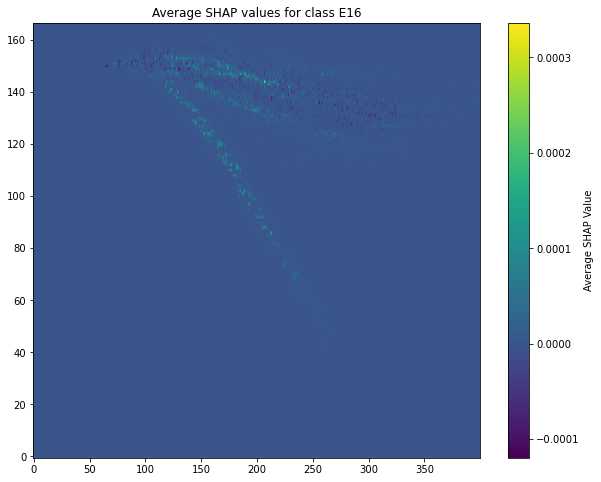

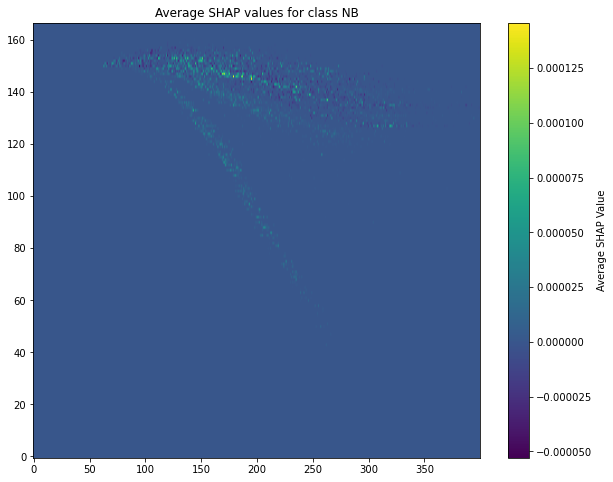

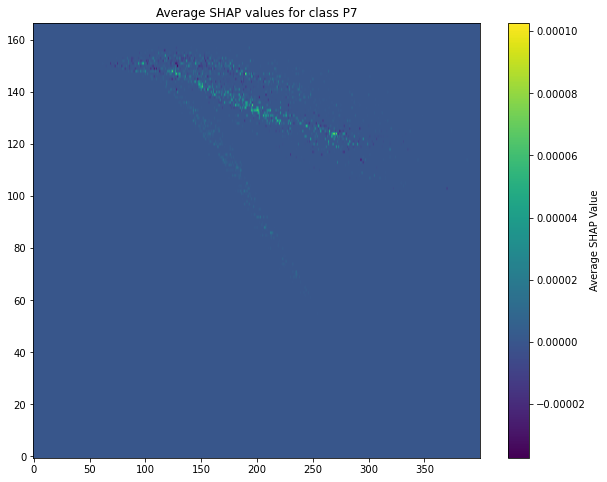

In [8]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Step 1: Extract ages from file names (as done before)
def extract_age(name):
    return name.split('_')[0]  # Assuming age is the first part of the filename

# Assuming names_k8 and flattened_k8 are already defined
ages_k8 = [extract_age(name) for name in names_k8]
X = np.array(flattened_k8)
y = np.array(ages_k8)

# Number of trials for train-test splitting
num_trials = 20

# Prepare variables to store SHAP values for averaging
shap_values_aggregate = None  # To store the sum of SHAP values across trials
n=0 # account for the number of trials with accuracy > 0.7
# Loop for multiple random splits
for trial in range(num_trials):
    print(f"Trial {trial + 1}/{num_trials}")

    # Step 2: Randomize train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40+trial)

    # Step 3: Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=40)
    rf_classifier.fit(X_train, y_train)
    print(f"Model training score: {rf_classifier.score(X_test, y_test)}")

    if rf_classifier.score(X_test, y_test) > 0.7:
        # Step 4: Initialize SHAP explainer and compute SHAP values
        n+=1
        explainer = shap.TreeExplainer(rf_classifier)
        shap_values = explainer.shap_values(X_test)

        # Step 5: Iterate through each class
        class_order = rf_classifier.classes_
        if shap_values_aggregate is None:
            # Initialize aggregate storage with the correct shape
            shap_values_aggregate = np.zeros((len(class_order), ypoints, xpoints))

        for k in range(len(class_order)):  # shap_values.shape[2] corresponds to number of classes
            shap_values_class = shap_values[:, :, k]  # SHAP values for class k
            class_index = np.where(y_test == class_order[k])[0]
            
            if class_index.size > 0:
                # Compute the mean SHAP values for this class in this trial
                chosen_shap_values = shap_values_class[class_index]
                shap_values_mean = chosen_shap_values.mean(axis=0)
                shap_image = shap_values_mean.reshape(ypoints, xpoints)

                # Sum SHAP values for averaging later
                shap_values_aggregate[k] += shap_image

# Step 6: Average the SHAP values across all trials
shap_values_avg = shap_values_aggregate / n

# Step 7: Visualize the averaged SHAP values for each class
for k in range(len(class_order)):
    shap_image_avg = shap_values_avg[k]

    # Optionally downsample the image for better visualization
    downsampled_importance = block_reduce(shap_image_avg, block_size=(3, 1), func=np.mean)

    # Plot the SHAP values as an image
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value')
    plt.title(f"Average SHAP values for class {class_order[k]}")
    plt.show()


#### sum across all classification trials first and then average

Trial 1/20
Model training score: 0.42857142857142855
Trial 2/20
Model training score: 0.7142857142857143
Trial 3/20
Model training score: 0.7142857142857143
Trial 4/20
Model training score: 0.7142857142857143
Trial 5/20
Model training score: 0.8571428571428571
Trial 6/20
Model training score: 0.8571428571428571
Trial 7/20
Model training score: 0.7142857142857143
Trial 8/20
Model training score: 1.0
Trial 9/20
Model training score: 0.7142857142857143
Trial 10/20
Model training score: 0.8571428571428571
Trial 11/20
Model training score: 0.5714285714285714
Trial 12/20
Model training score: 0.7142857142857143
Trial 13/20
Model training score: 0.7142857142857143
Trial 14/20
Model training score: 0.7142857142857143
Trial 15/20
Model training score: 0.7142857142857143
Trial 16/20
Model training score: 0.7142857142857143
Trial 17/20
Model training score: 0.5714285714285714
Trial 18/20
Model training score: 1.0
Trial 19/20
Model training score: 0.8571428571428571
Trial 20/20
Model training scor

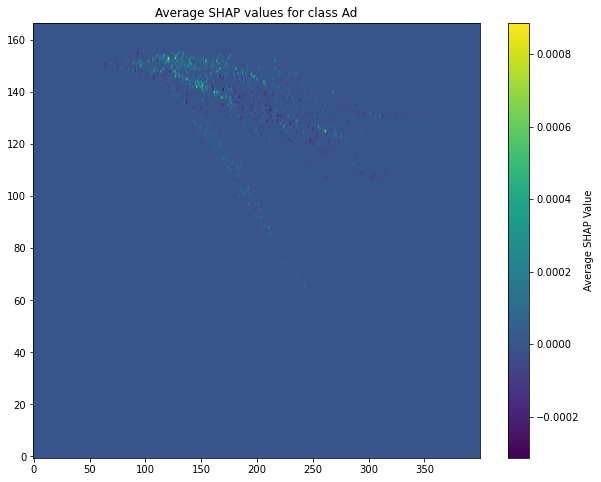

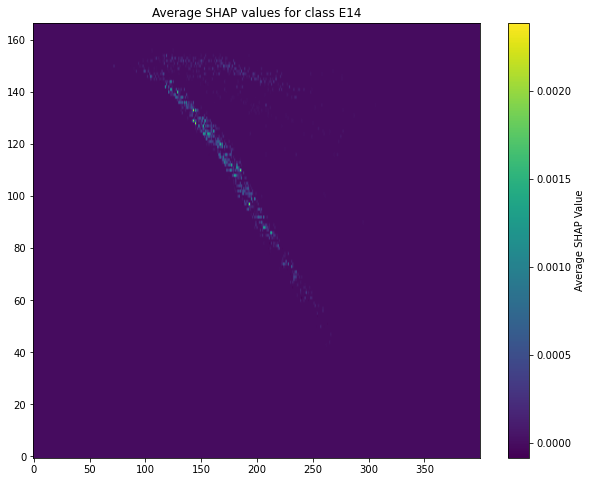

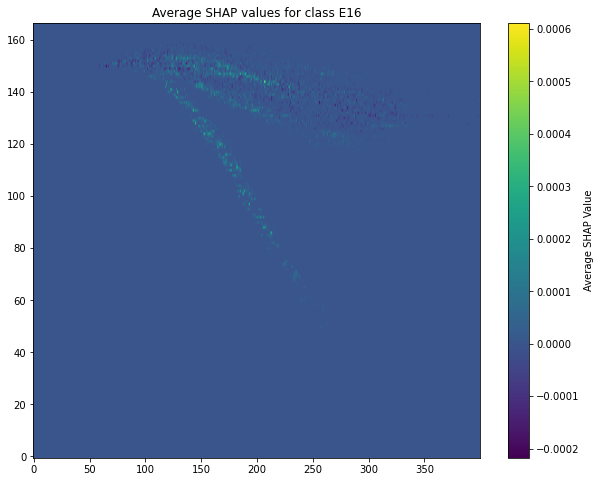

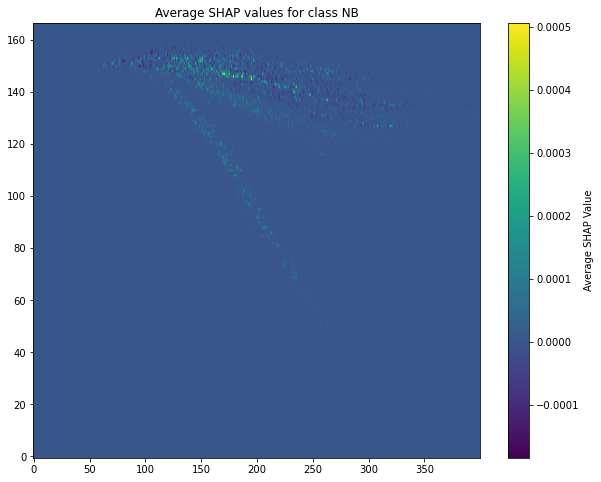

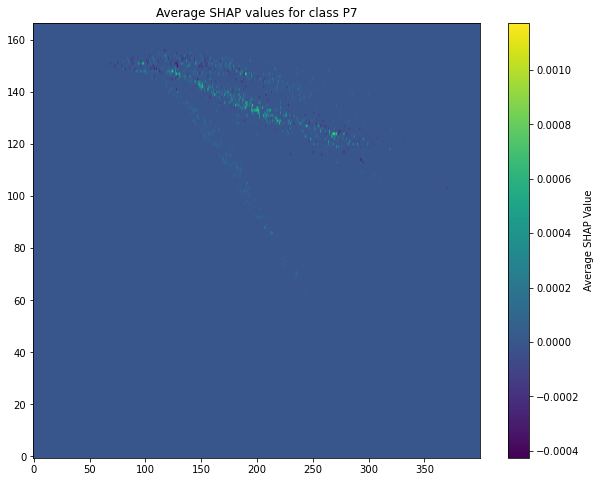

In [12]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Step 1: Extract ages from file names (as done before)
def extract_age(name):
    return name.split('_')[0]  # Assuming age is the first part of the filename

# Assuming names_k8 and flattened_k8 are already defined
class_order = rf_classifier.classes_
ages_k8 = [extract_age(name) for name in names_k8]
X = np.array(flattened_k8)
y = np.array(ages_k8)
# Number of trials for train-test splitting
num_trials = 20

# Prepare variables to store SHAP values for averaging
shap_values_aggregate = None  # To store the sum of SHAP values across trials
n=np.zeros(len(class_order)) # account for the number of trials with accuracy > 0.7
# Loop for multiple random splits
for trial in range(num_trials):
    print(f"Trial {trial + 1}/{num_trials}")

    # Step 2: Randomize train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40+trial)

    # Step 3: Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=40)
    rf_classifier.fit(X_train, y_train)
    print(f"Model training score: {rf_classifier.score(X_test, y_test)}")

    if rf_classifier.score(X_test, y_test) > 0.7:
        # Step 4: Initialize SHAP explainer and compute SHAP values
        explainer = shap.TreeExplainer(rf_classifier)
        shap_values = explainer.shap_values(X_test)

        # Step 5: Iterate through each class
        class_order = rf_classifier.classes_
        if shap_values_aggregate is None:
            # Initialize aggregate storage with the correct shape
            shap_values_aggregate = np.zeros((len(class_order), ypoints, xpoints))

        for k in range(len(class_order)):  # shap_values.shape[2] corresponds to number of classes
            shap_values_class = shap_values[:, :, k]  # SHAP values for class k
            class_index = np.where(y_test == class_order[k])[0]
            if class_index.size > 0:
                # Compute the mean SHAP values for this class in this trial
                chosen_shap_values = shap_values_class[class_index]
                shap_values_mean = chosen_shap_values.sum(axis=0)
                shap_image = shap_values_mean.reshape(ypoints, xpoints)

                # Sum SHAP values for averaging later
                shap_values_aggregate[k] += shap_image
                n[k]+=len(class_index)



# Step 7: Visualize the averaged SHAP values for each class
for k in range(len(class_order)):
    shap_image_avg = shap_values_aggregate[k]/n[k]

    # Optionally downsample the image for better visualization
    downsampled_importance = block_reduce(shap_image_avg, block_size=(3, 1), func=np.mean)

    # Plot the SHAP values as an image
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value')
    plt.title(f"Average SHAP values for class {class_order[k]}")
    plt.show()


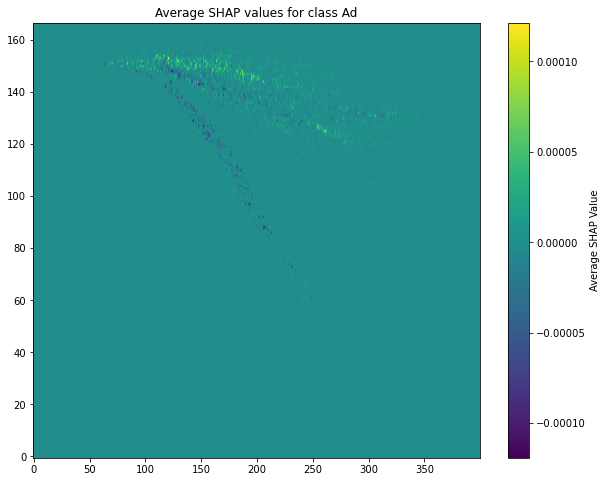

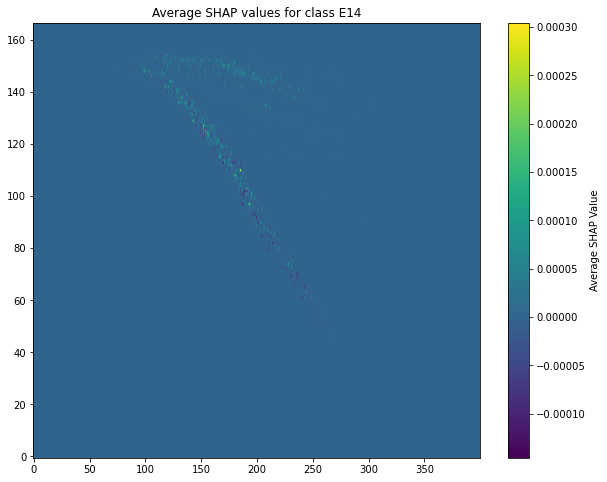

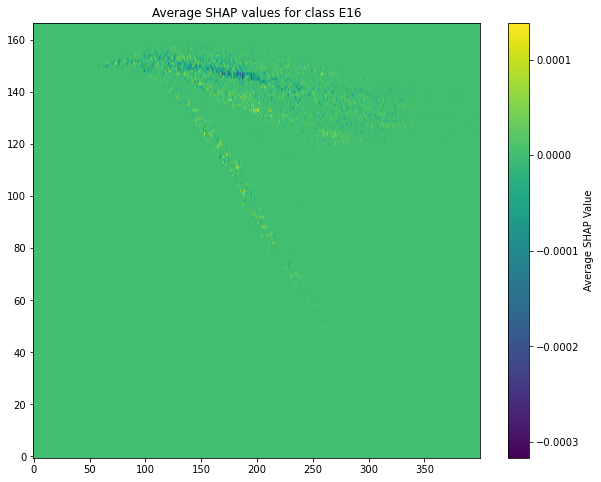

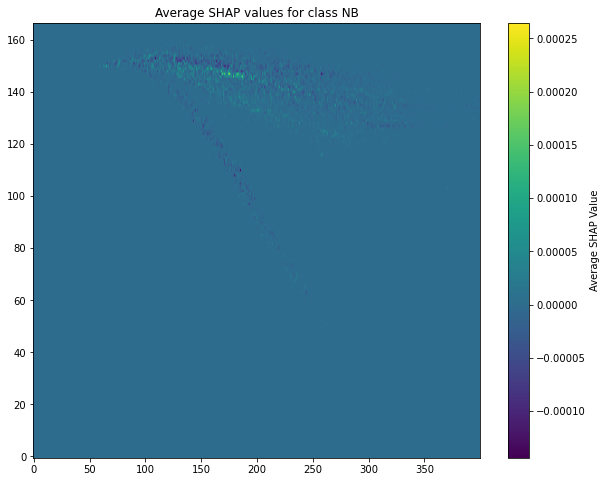

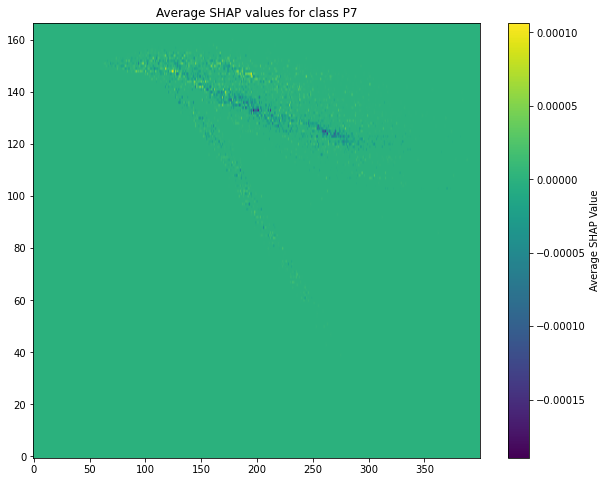

In [13]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Step 1: Extract ages from file names (as done before)
def extract_age(name):
    return name.split('_')[0]  # Assuming age is the first part of the filename

# Assuming names_k8 and flattened_k8 are already defined
ages_k8 = [extract_age(name) for name in names_k8]
X = np.array(flattened_k8)
y = np.array(ages_k8)

# Number of trials for train-test splitting
num_trials = 20

# Prepare variables to store SHAP values for averaging
shap_values_aggregate = None  # To store the sum of SHAP values across trials
n=0 # account for the number of trials with accuracy > 0.7
# Loop for multiple random splits
for trial in range(num_trials):
    # print(f"Trial {trial + 1}/{num_trials}")

    # Step 2: Randomize train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=40+trial)

    # Step 3: Initialize and train the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=40)
    rf_classifier.fit(X_train, y_train)
    # print(f"Model training score: {rf_classifier.score(X_test, y_test)}")

    if rf_classifier.score(X_test, y_test) > 0.7:
        # Step 4: Initialize SHAP explainer and compute SHAP values
        n+=1
        explainer = shap.TreeExplainer(rf_classifier)
        shap_values = explainer.shap_values(X_test)

        # Step 5: Iterate through each class
        class_order = rf_classifier.classes_
        if shap_values_aggregate is None:
            # Initialize aggregate storage with the correct shape
            shap_values_aggregate = np.zeros((len(class_order), ypoints, xpoints))

        for k in range(len(class_order)):  # shap_values.shape[2] corresponds to number of classes
            shap_values_class = shap_values[:, :, k]  # SHAP values for class k
            # Compute the mean SHAP values for this class in this trial
            chosen_shap_values = shap_values_class[class_index]
            shap_values_mean = shap_values_class.mean(axis=0)
            shap_image = shap_values_mean.reshape(ypoints, xpoints)

            # Sum SHAP values for averaging later
            shap_values_aggregate[k] += shap_image

# Step 6: Average the SHAP values across all trials
shap_values_avg = shap_values_aggregate / n

# Step 7: Visualize the averaged SHAP values for each class
for k in range(len(class_order)):
    shap_image_avg = shap_values_avg[k]

    # Optionally downsample the image for better visualization
    downsampled_importance = block_reduce(shap_image_avg, block_size=(3, 1), func=np.mean)

    # Plot the SHAP values as an image
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value')
    plt.title(f"Average SHAP values for class {class_order[k]}")
    plt.show()


### binary classifications with shap (actually used for presentation)

Processing age group: Ad
average accuracy for age Ad is 0.9071428571428569


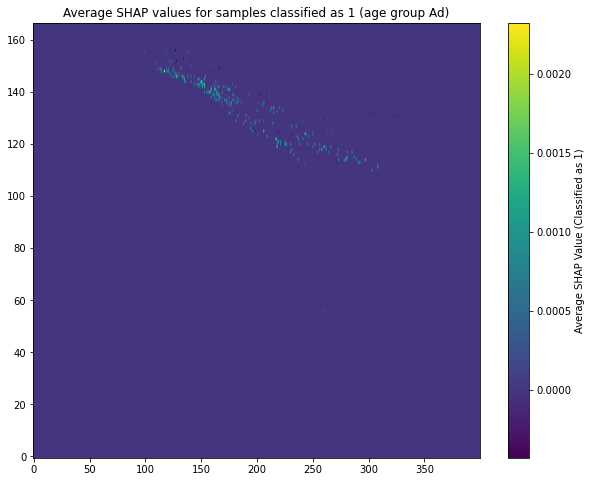

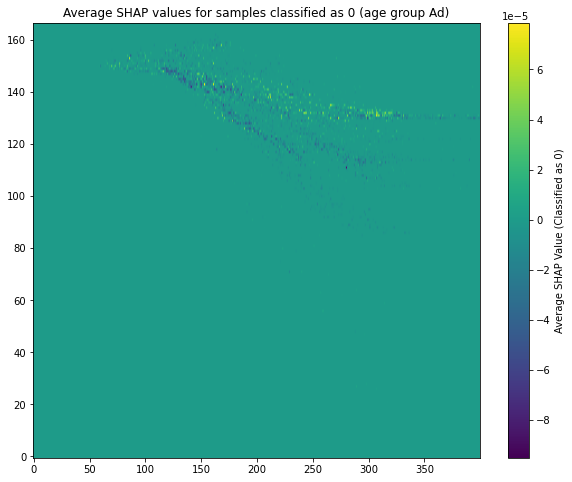

Processing age group: E14
average accuracy for age E14 is 1.0


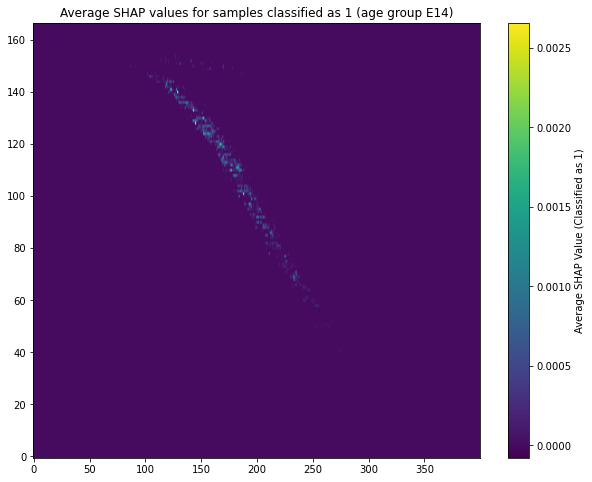

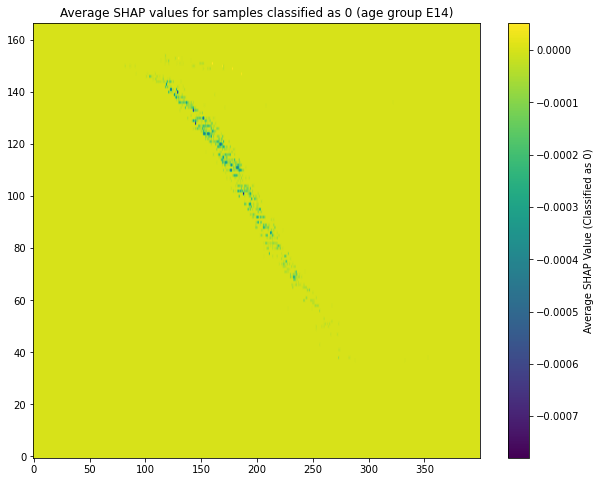

Processing age group: E16
average accuracy for age E16 is 0.7499999999999999


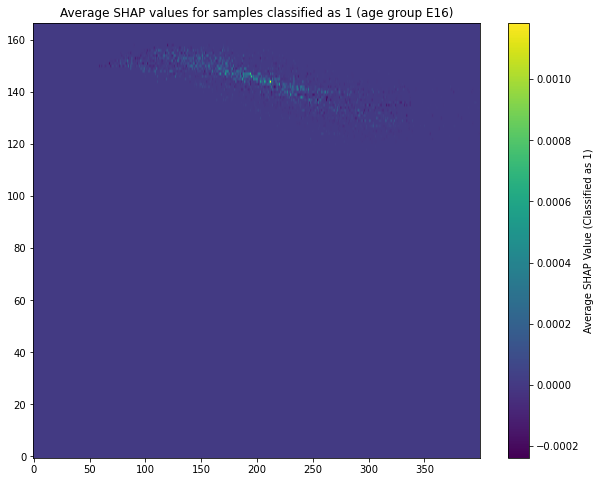

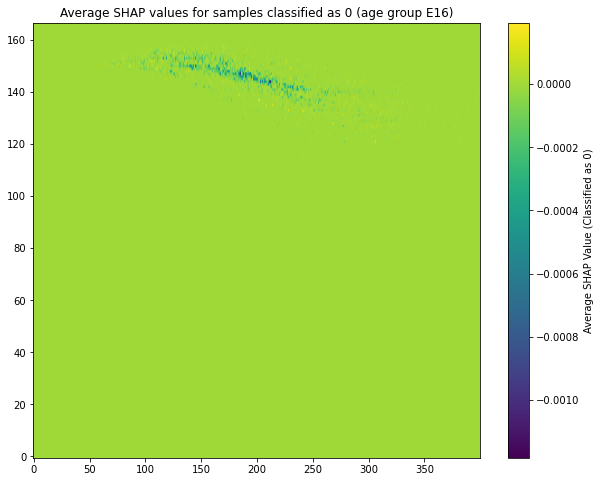

Processing age group: NB
average accuracy for age NB is 0.8107142857142857


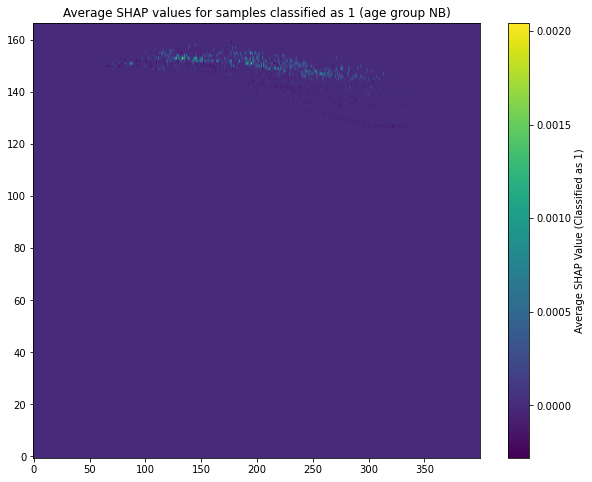

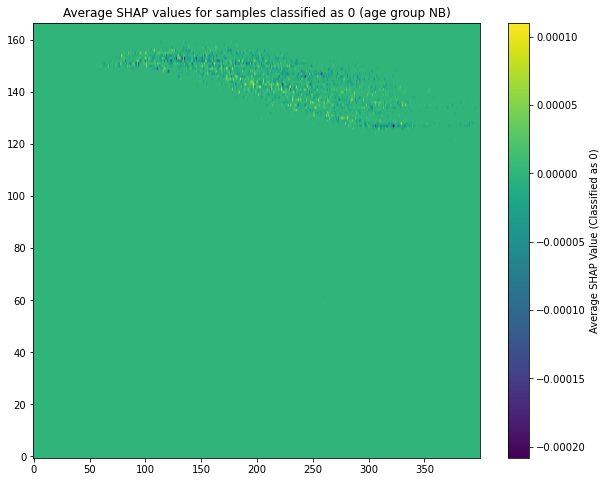

Processing age group: P7
average accuracy for age P7 is 0.9249999999999998


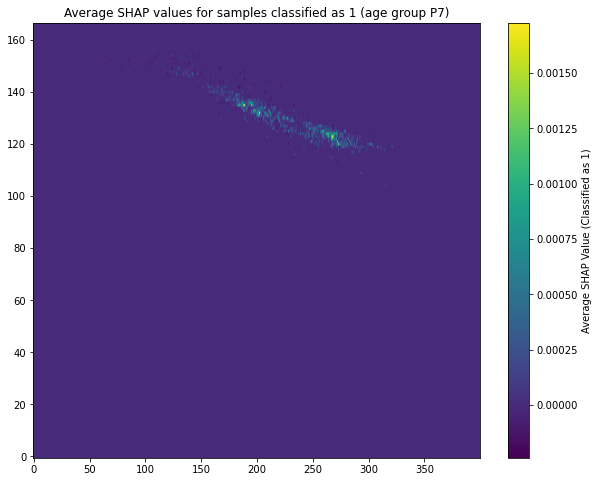

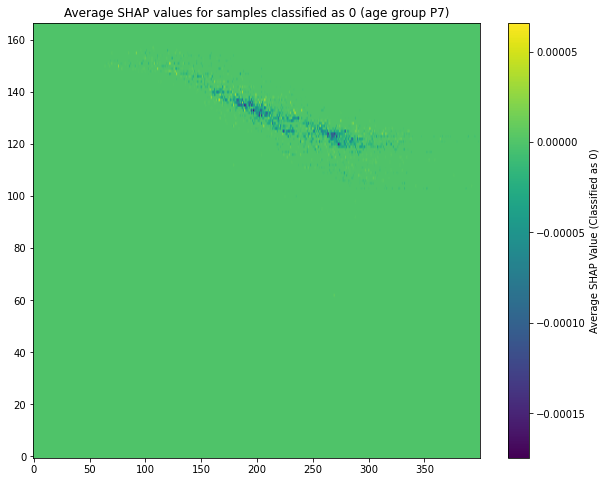

In [3]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Step 1: Extract ages from file names
def extract_age(name):
    return name.split('_')[0]  # Assuming age is the first part of the filename

# Assuming names_k8 and flattened_k8 are already defined
ages_k8 = [extract_age(name) for name in names_k8]
X = np.array(flattened_k8)
y = np.array(ages_k8)
unique_ages = np.unique(y)  # Find unique ages in the dataset
ypoints, xpoints = 500, 400  # Set the appropriate image dimensions

# Number of trials for train-test splitting
num_trials = 20

# Loop over each unique age to create binary classification problems
for age in unique_ages:
    print(f"Processing age group: {age}")
    
    # Binary classification: 1 if the sample belongs to the current age, 0 otherwise
    binary_labels = np.where(y == age, 1, 0)
    
    # Prepare variables to store SHAP values for averaging
    shap_values_aggregate_1 = None  # To store the sum of SHAP values for class 1 across trials
    shap_values_aggregate_0 = None  # To store the sum of SHAP values for class 0 across trials
    n_1 = 0  # Counter for trials where samples are classified as 1
    n_0 = 0  # Counter for trials where samples are classified as 0
    scores = []
    # Loop for multiple random splits
    for trial in range(num_trials):
        # print(f"Trial {trial + 1}/{num_trials}")

        # Step 2: Randomize train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, binary_labels, test_size=0.2, random_state=40+trial)

        # Step 3: Initialize and train the Random Forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=100, random_state=40)
        rf_classifier.fit(X_train, y_train)
        score = rf_classifier.score(X_test, y_test)
        scores.append(score)
        # print(f"Model training score: {score}")

        if score > 0.8:
            # Step 4: Initialize SHAP explainer and compute SHAP values
            explainer = shap.TreeExplainer(rf_classifier)
            shap_values = explainer.shap_values(X_test)

            # Step 5: Since this is binary classification, shap_values[1] gives SHAP for class 1
            shap_values_class = shap_values[:, :, 1]  # SHAP values for class "age"

            # Step 6: Get predicted classes
            y_pred = rf_classifier.predict(X_test)

            # Separate SHAP values for class 1 and class 0
            shap_values_1 = shap_values_class[y_pred == 1]  # Samples classified as 1
            shap_values_0 = shap_values_class[y_pred == 0]  # Samples classified as 0

            # Initialize aggregate storage for class 1 and class 0
            if shap_values_aggregate_1 is None:
                shap_values_aggregate_1 = np.zeros((ypoints, xpoints))
            if shap_values_aggregate_0 is None:
                shap_values_aggregate_0 = np.zeros((ypoints, xpoints))

            # Sum SHAP values for class 1
            if len(shap_values_1) > 0:
                shap_values_mean_1 = shap_values_1.mean(axis=0)  # Average over samples classified as 1
                shap_image_1 = shap_values_mean_1.reshape(ypoints, xpoints)
                shap_values_aggregate_1 += shap_image_1
                n_1 += 1

            # Sum SHAP values for class 0
            if len(shap_values_0) > 0:
                shap_values_mean_0 = shap_values_0.mean(axis=0)  # Average over samples classified as 0
                shap_image_0 = shap_values_mean_0.reshape(ypoints, xpoints)
                shap_values_aggregate_0 += shap_image_0
                n_0 += 1

    # Step 7: Average the SHAP values across all trials
    if n_1 > 0:
        shap_values_avg_1 = shap_values_aggregate_1 / n_1
    if n_0 > 0:
        shap_values_avg_0 = shap_values_aggregate_0 / n_0
    print(f'average accuracy for age {age} is {np.mean(scores)}')
    # Step 8: Visualize the averaged SHAP values for class 1 (samples classified as 1)
    downsampled_importance_1 = block_reduce(shap_values_avg_1, block_size=(3, 1), func=np.mean)
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance_1, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value (Classified as 1)')
    plt.title(f"Average SHAP values for samples classified as 1 (age group {age})")
    plt.show()

    # Step 9: Visualize the averaged SHAP values for class 0 (samples classified as 0)
    downsampled_importance_0 = block_reduce(shap_values_avg_0, block_size=(3, 1), func=np.mean)
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance_0, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value (Classified as 0)')
    plt.title(f"Average SHAP values for samples classified as 0 (age group {age})")
    plt.show()


## SHAP value of K14

Computed ECT image for NB_K14_mask_r_6.tif


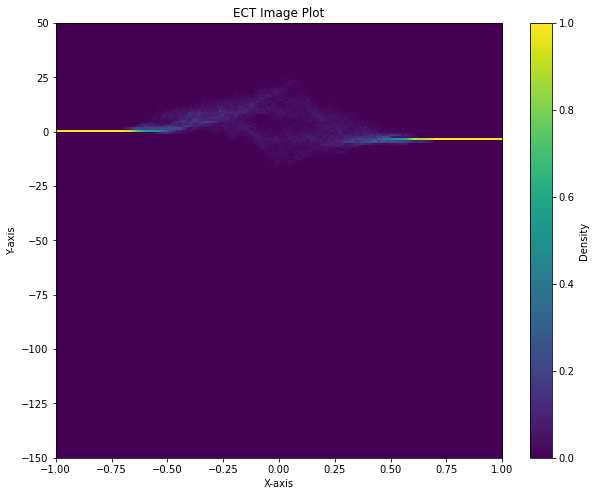

Computed ECT image for Ad_K14_mask_1.tif


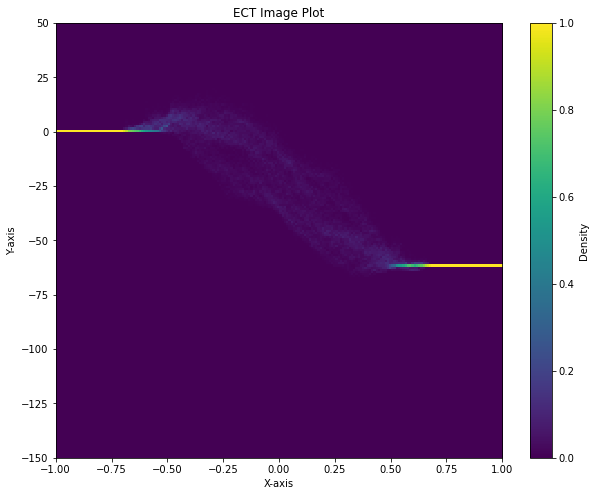

Computed ECT image for P7_K14_mask_5.tif


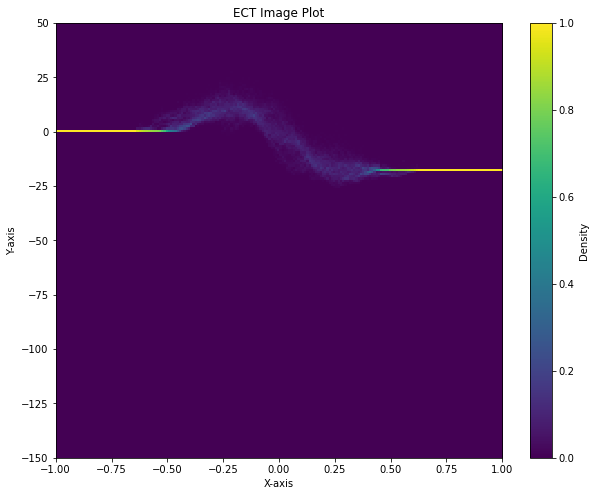

Computed ECT image for Ad_K14_mask_5.tif


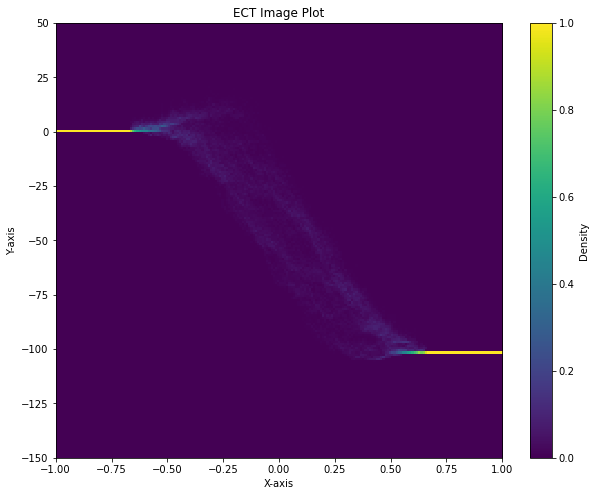

Computed ECT image for NB_K14_mask_r_2.tif


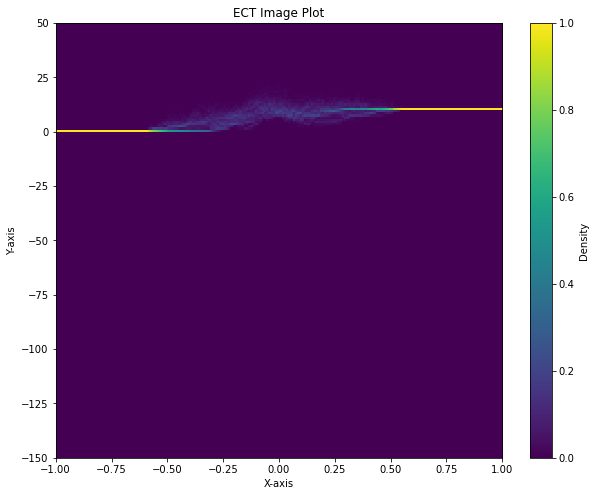

Computed ECT image for NB_K14_mask_l_7.tif


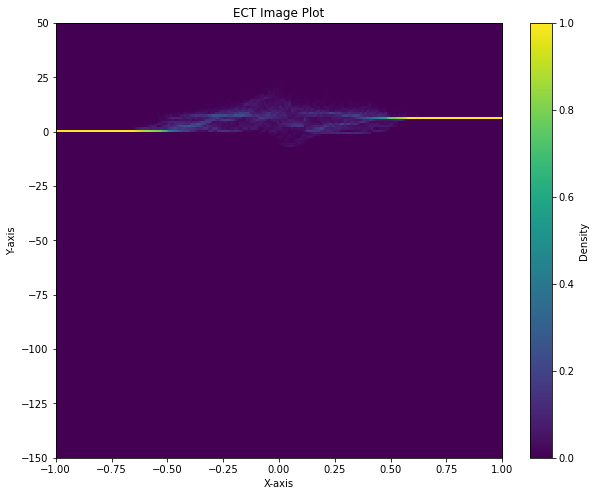

Computed ECT image for P7_K14_mask_1.tif


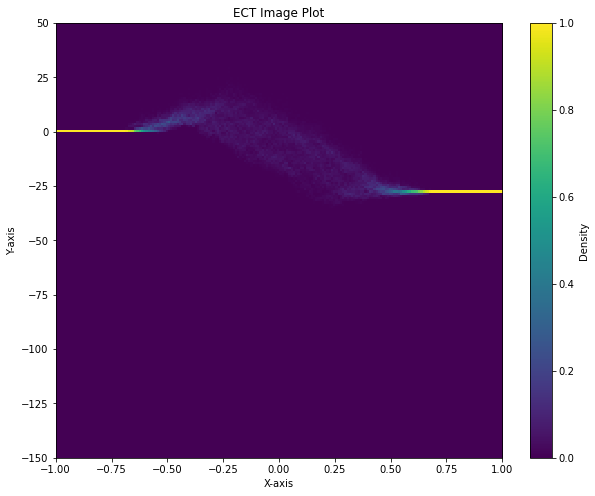

Computed ECT image for NB_K14_mask_l_5.tif


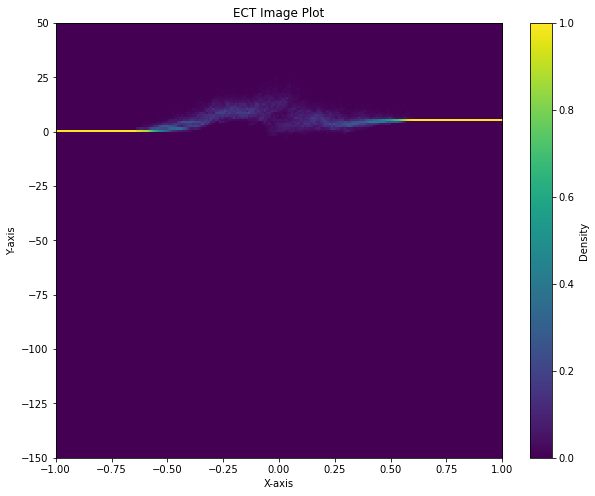

Computed ECT image for P7_K14_mask_7.tif


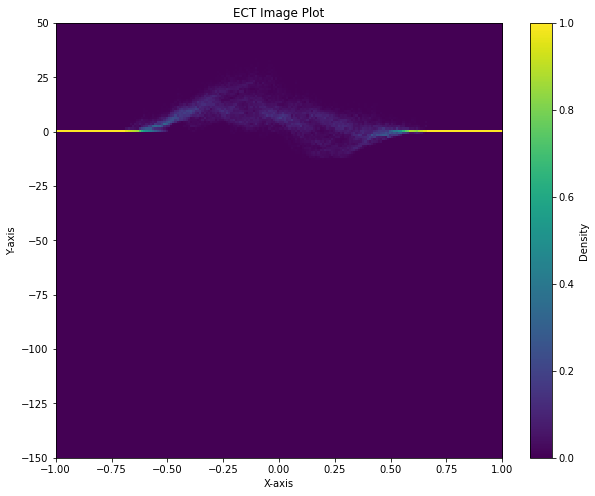

Computed ECT image for P7_K14_mask_2.tif


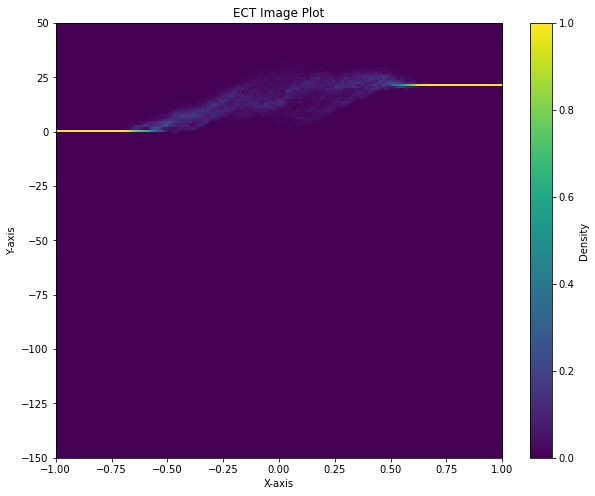

Computed ECT image for P7_K14_mask_6.tif


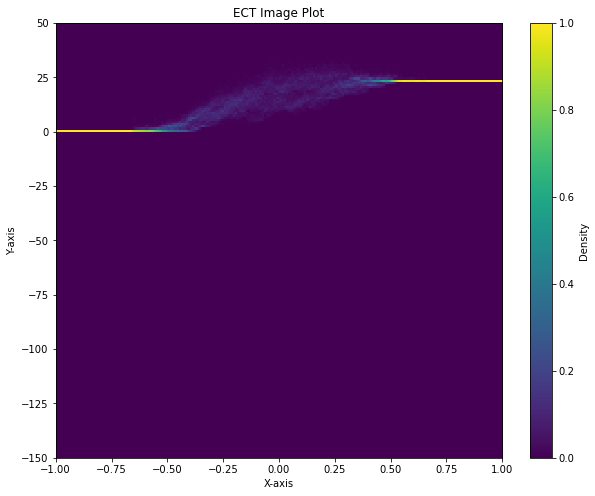

Computed ECT image for Ad_K14_mask_2.tif


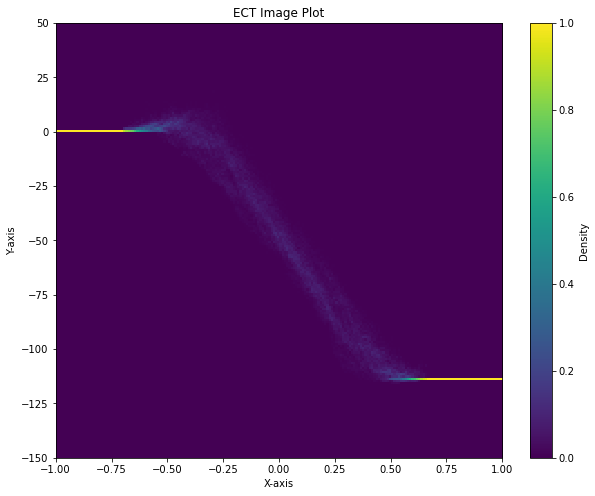

Computed ECT image for NB_K14_mask_r_4.tif


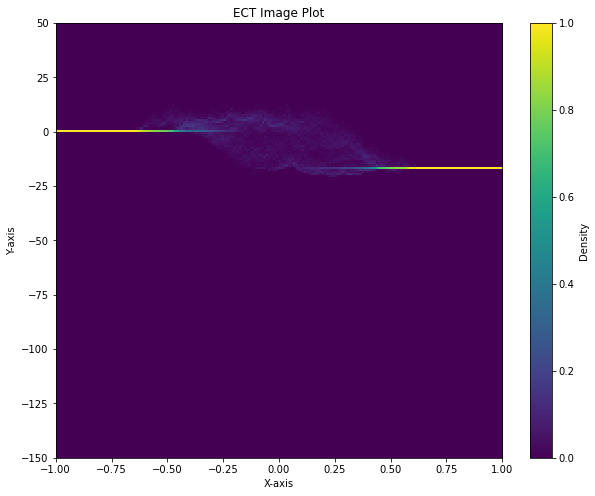

Computed ECT image for Ad_K14_mask_3.tif


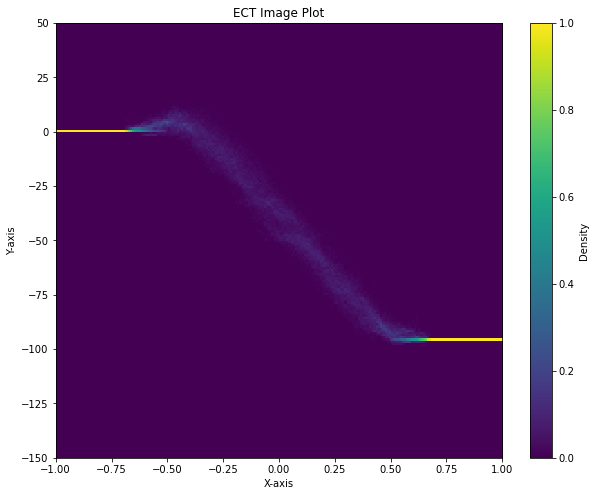

Computed ECT image for NB_K14_mask_l_2.tif


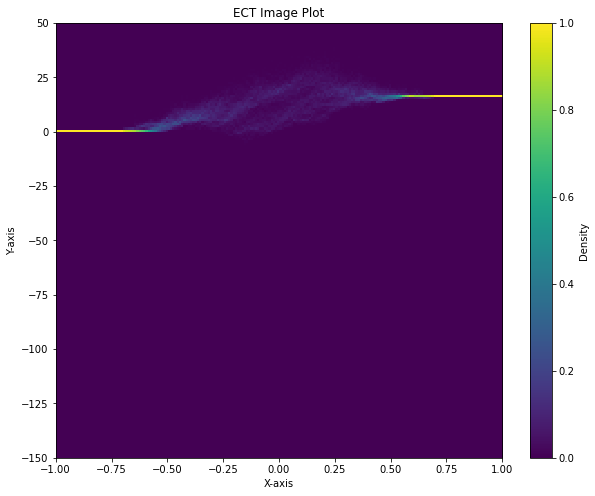

Computed ECT image for NB_K14_mask_r_1.tif


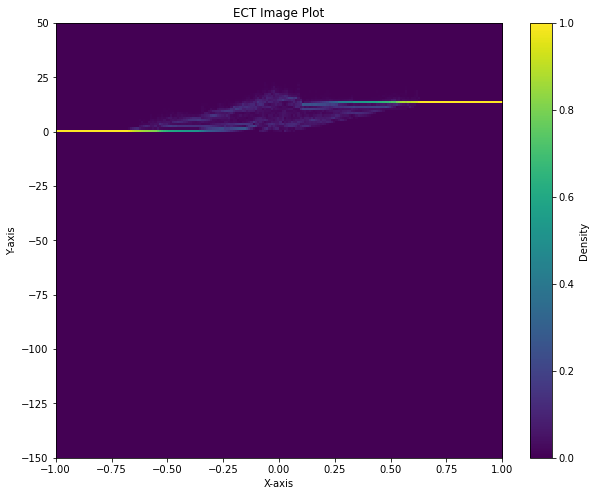

Computed ECT image for NB_K14_mask_l_4.tif


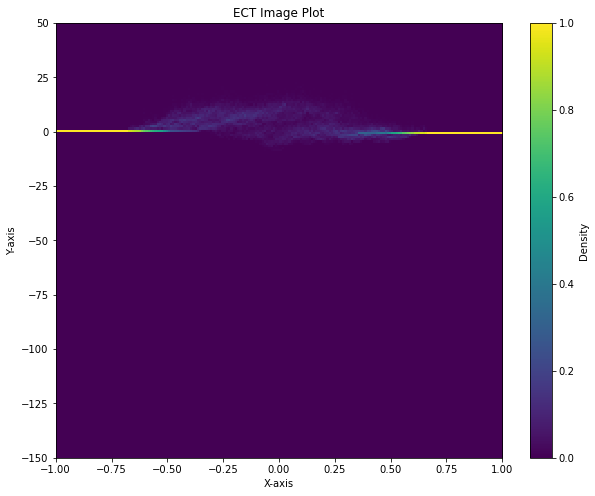

Computed ECT image for NB_K14_mask_r_5.tif


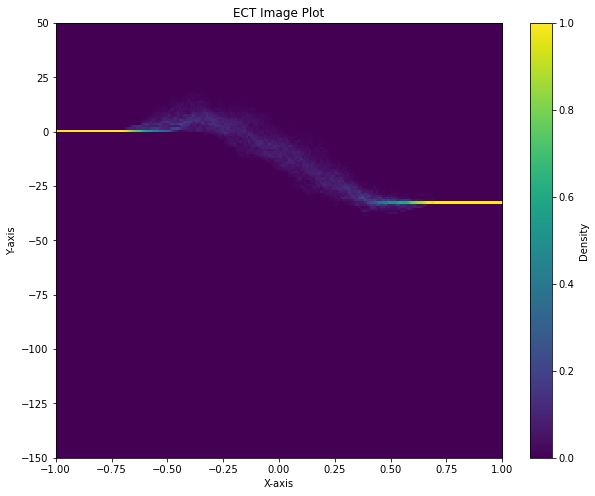

Computed ECT image for Ad_K14_mask_7.tif


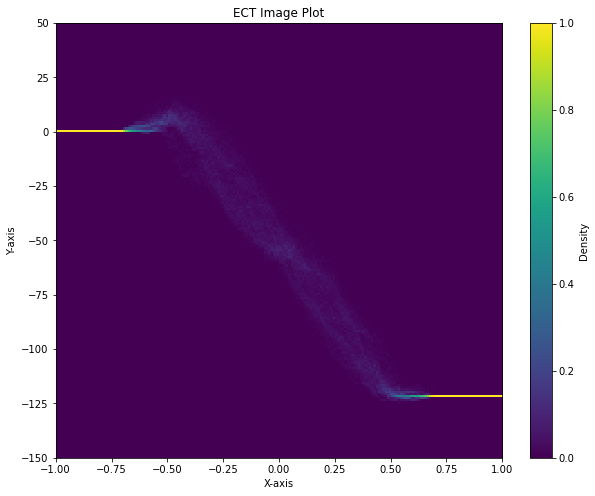

Computed ECT image for Ad_K14_mask_4.tif


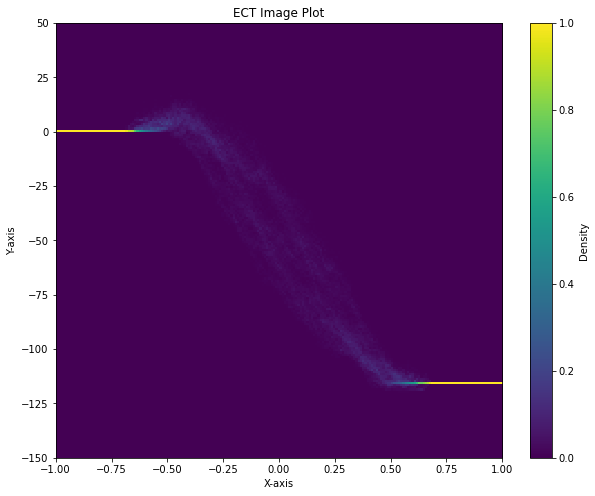

Computed ECT image for NB_K14_mask_r_7.tif


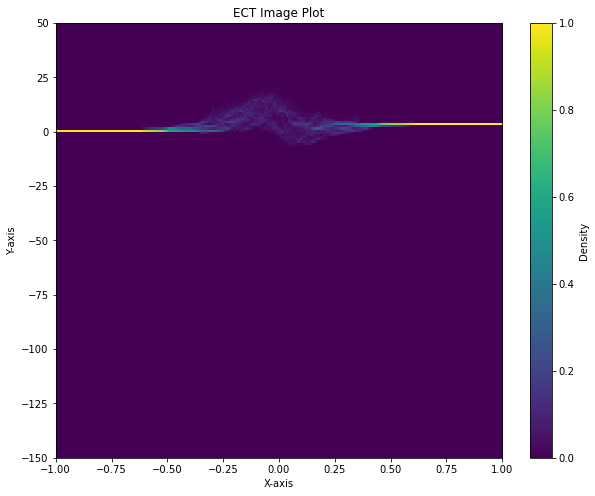

Computed ECT image for Ad_K14_mask_6.tif


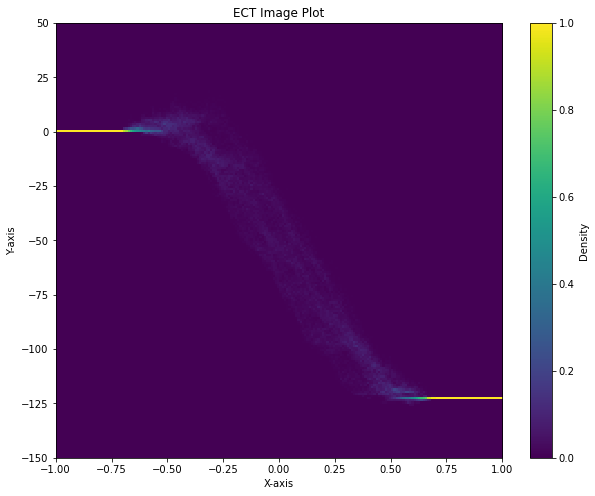

Computed ECT image for NB_K14_mask_l_1.tif


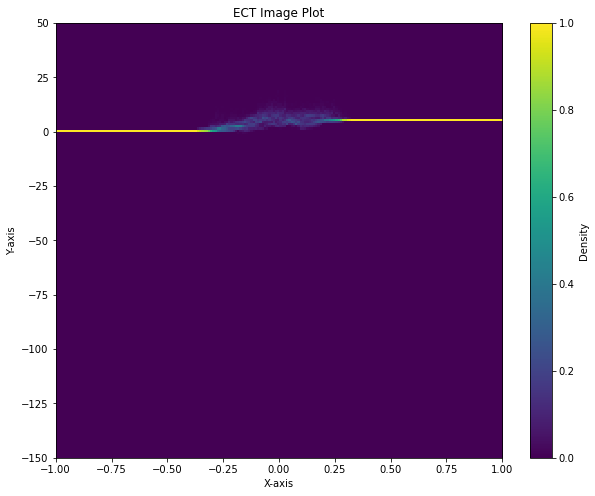

Computed ECT image for NB_K14_mask_l_6.tif


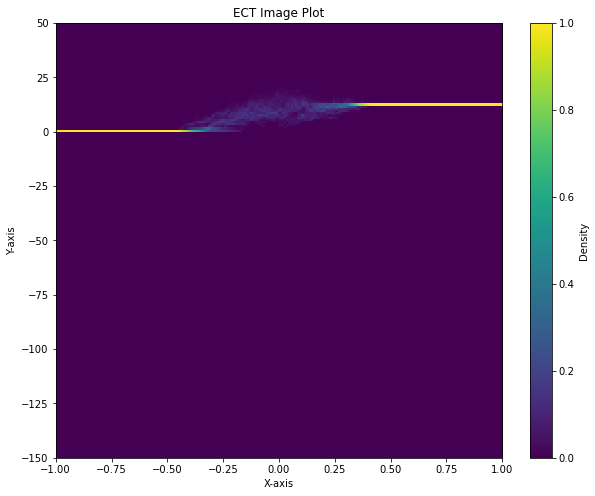

Computed ECT image for P7_K14_mask_3.tif


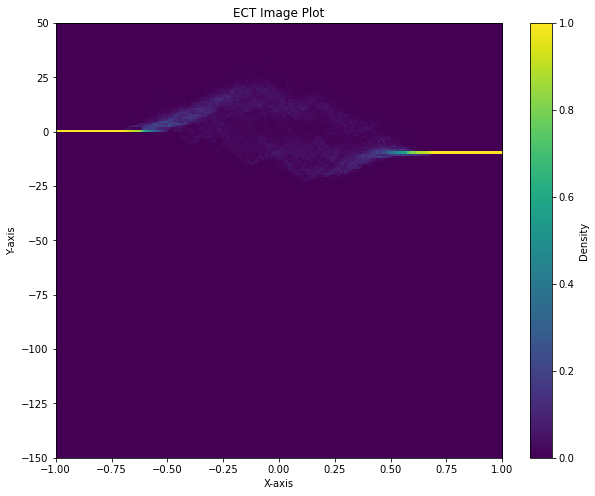

Computed ECT image for P7_K14_mask_4.tif


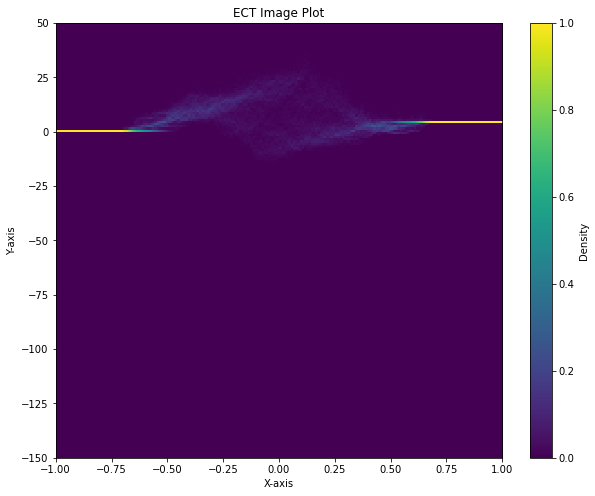

Computed ECT image for NB_K14_mask_l_3.tif


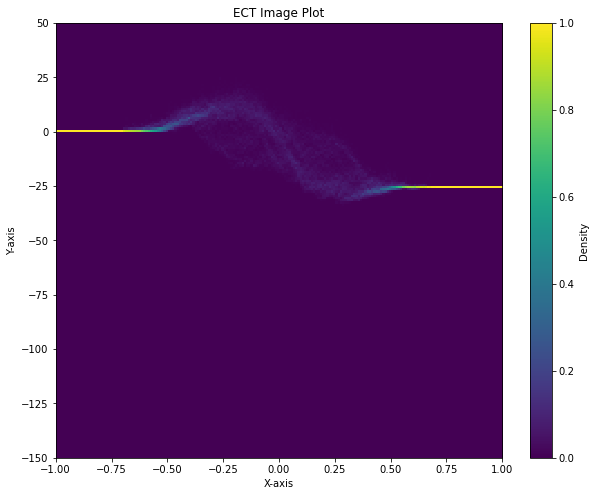

Computed ECT image for NB_K14_mask_r_3.tif


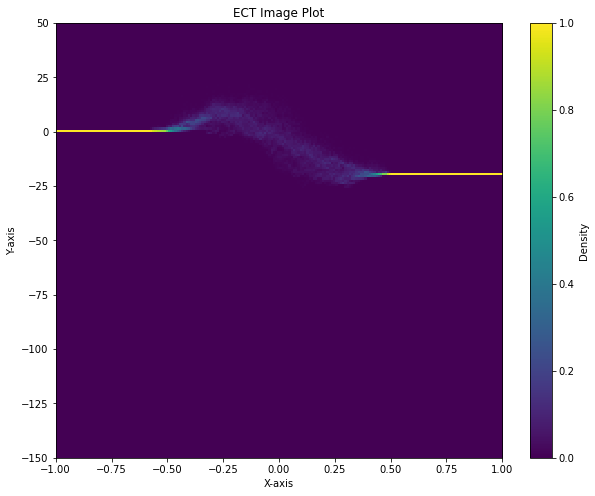

In [6]:
import os
import tifffile as tiff
import eucalc as ec
import matplotlib.colors as mcolors
from PIL import Image

class EctImg:
    def __init__(self, img, k=20, xinterval=(-1., 1.), xpoints=100, yinterval=(-1., 1.), ypoints=100, factor=3):
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints = xpoints
        self.ypoints = ypoints
        self.image = self.compute(img, k, xinterval, xpoints, yinterval, ypoints, factor)
    def compute(self, img, k, xinterval, xpoints, yinterval, ypoints, factor):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.linspace(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]

        image = np.zeros((ypoints, xpoints), dtype=float)
        yvalues = np.linspace(yinterval[0], yinterval[1], ypoints+1, endpoint=True)
        for i in range(xpoints):
            column = ect1[:, i]
            for j in range(ypoints):
                value = 0
                if j < ypoints-1:
                    value = len(np.where((yvalues[j] <= column) & (column < yvalues[j+1]))[0])/k
                else:
                    value = len(np.where((yvalues[j] <= column) & (column <= yvalues[j+1]))[0])/k
                image[j, i] = value
        return image
    
    def plot(self):
        plt.figure(figsize=(10, 8))
        # Using xinterval and yinterval directly in extent
        plt.imshow(self.image, aspect='auto', extent=[self.xinterval[0], self.xinterval[1], self.yinterval[0], self.yinterval[1]], origin='lower', interpolation='none')
        plt.colorbar(label='Density')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('ECT Image Plot')
        plt.show()


def compute_ExIm(names, datafolder):
    ExImage = []
    
    for nm in names: 
        file_path = os.path.join(datafolder, nm)
        with Image.open(file_path) as img:
            img_array = np.array(img)
        
        ect = EctImg(img_array, k=480, xinterval=(-1., 1.), xpoints=200, yinterval=(-150., 50.), ypoints=200, factor=3)
        print(f"Computed ECT image for {nm}")
        ect.plot()
        exim = ect.compute(img_array, k=480, xinterval=(-1, 1.), xpoints=200, yinterval=(-150., 50.), ypoints=200, factor=3)
        ExImage.append(exim)

    return ExImage


def extract_age(name):
    return name.split('_')[0]

unique_ages = list(set(extract_age(name) for name in names_k14))

# Create a color map based on unique ages
cmap = cm.get_cmap('viridis', len(unique_ages))
age_to_color = {age: cmap(i) for i, age in enumerate(unique_ages)}

exim_k14 = compute_ExIm(names_k14, datafolder)
flattened_k14 = [image.flatten() for image in exim_k14]



In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# Step 1: Extract ages from file names
def extract_age(name):
    return name.split('_')[0]  # Assuming age is the first part of the filename

ages_k14 = [extract_age(name) for name in names_k14]

# Step 2: Prepare the feature vectors (flattened images) and corresponding labels (ages)
X = np.array(flattened_k14)
y = np.array(ages_k14)

for n in [10, 20, 30, 40, 50,60, 70, 100]:
    # Step 3: Initialize the Random Forest classifier
    rf_classifier = RandomForestClassifier(n_estimators=n, random_state=42)

    # Step 4: Perform cross-validation
    cv_scores = cross_val_score(rf_classifier, X, y, cv=5)  # 5-fold cross-validation

    # Step 5: Print the cross-validation scores
    print(f"Cross-validation scores of {n}: {cv_scores}")
    print(f"Mean cross-validation accuracy of {n}: {np.mean(cv_scores)}")

Cross-validation scores of 10: [0.83333333 0.83333333 0.66666667 1.         1.        ]
Mean cross-validation accuracy of 10: 0.8666666666666668
Cross-validation scores of 20: [0.83333333 0.66666667 0.66666667 1.         0.8       ]
Mean cross-validation accuracy of 20: 0.7933333333333333
Cross-validation scores of 30: [0.83333333 0.66666667 0.66666667 1.         0.8       ]
Mean cross-validation accuracy of 30: 0.7933333333333333
Cross-validation scores of 40: [0.83333333 0.66666667 0.66666667 1.         0.8       ]
Mean cross-validation accuracy of 40: 0.7933333333333333
Cross-validation scores of 50: [0.83333333 0.66666667 0.83333333 1.         0.8       ]
Mean cross-validation accuracy of 50: 0.8266666666666668
Cross-validation scores of 60: [0.66666667 0.66666667 0.66666667 1.         0.8       ]
Mean cross-validation accuracy of 60: 0.76
Cross-validation scores of 70: [0.66666667 0.66666667 0.83333333 1.         0.8       ]
Mean cross-validation accuracy of 70: 0.7933333333333333

Processing age group: Ad
mean Model training score: 0.9583333333333334


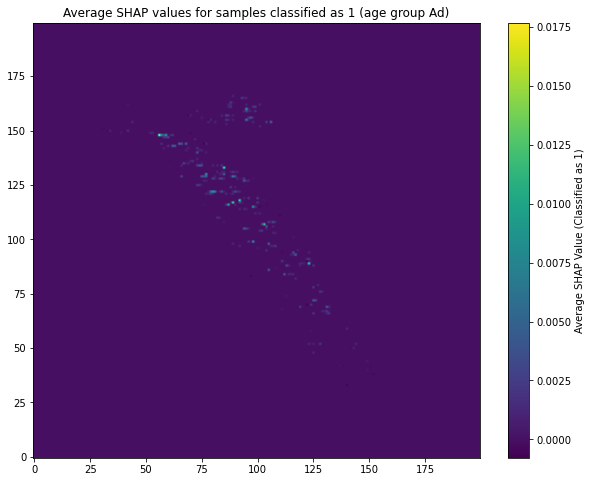

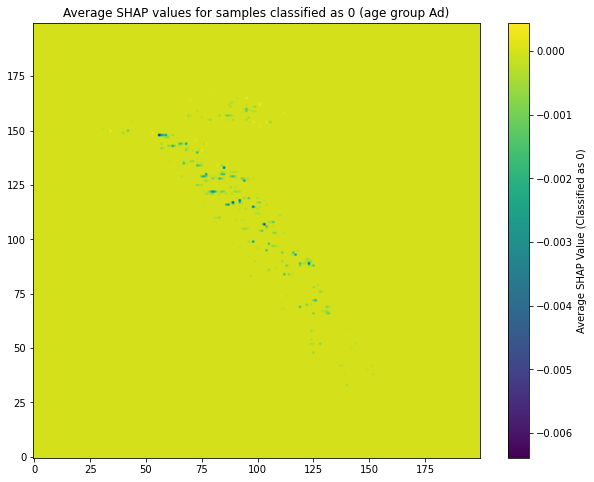

Processing age group: NB
mean Model training score: 0.7083333333333333


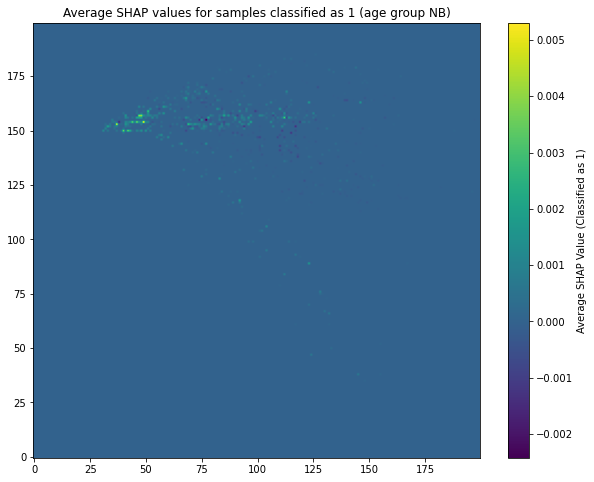

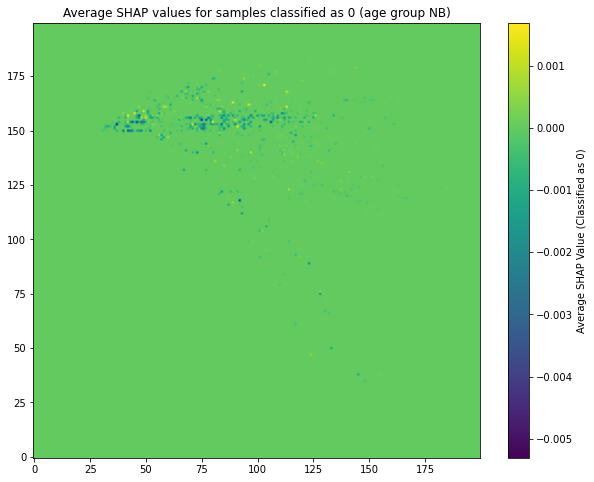

Processing age group: P7
mean Model training score: 0.8083333333333332


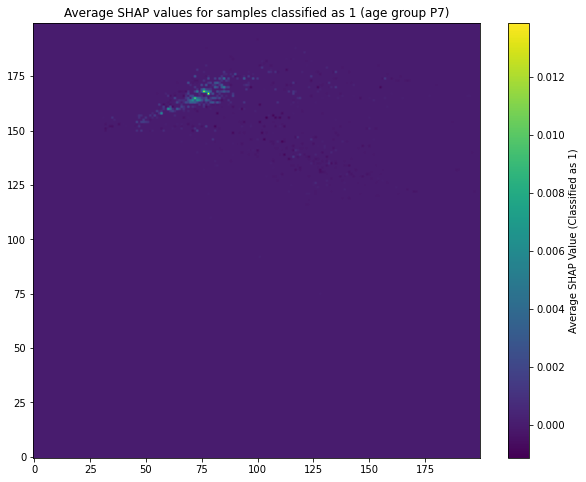

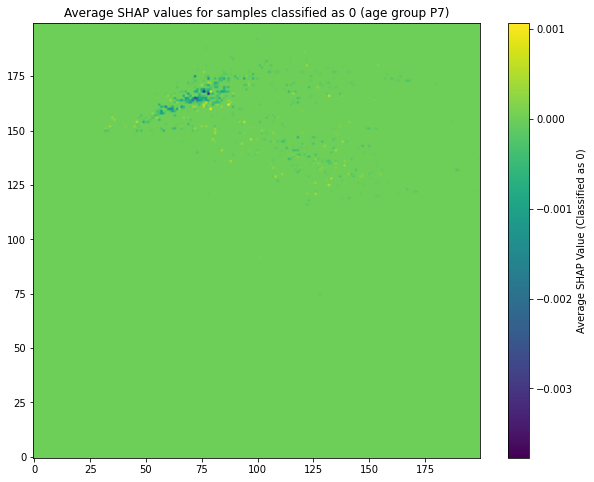

In [9]:
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import block_reduce

# Step 1: Extract ages from file names
def extract_age(name):
    return name.split('_')[0]  # Assuming age is the first part of the filename

# Assuming names_k8 and flattened_k8 are already defined
ages_k8 = [extract_age(name) for name in names_k14]
X = np.array(flattened_k14)
y = np.array(ages_k14)
unique_ages = np.unique(y)  # Find unique ages in the dataset
ypoints, xpoints = 200, 200  # Set the appropriate image dimensions

# Number of trials for train-test splitting
num_trials = 20

# Loop over each unique age to create binary classification problems
for age in unique_ages:
    print(f"Processing age group: {age}")
    
    # Binary classification: 1 if the sample belongs to the current age, 0 otherwise
    binary_labels = np.where(y == age, 1, 0)
    
    # Prepare variables to store SHAP values for averaging
    shap_values_aggregate_1 = None  # To store the sum of SHAP values for class 1 across trials
    shap_values_aggregate_0 = None  # To store the sum of SHAP values for class 0 across trials
    n_1 = 0  # Counter for trials where samples are classified as 1
    n_0 = 0  # Counter for trials where samples are classified as 0
    score =[]
    # Loop for multiple random splits
    for trial in range(num_trials):
        # print(f"Trial {trial + 1}/{num_trials}")

        # Step 2: Randomize train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, binary_labels, test_size=0.2, random_state=40+trial)

        # Step 3: Initialize and train the Random Forest classifier
        rf_classifier = RandomForestClassifier(n_estimators=50, random_state=42)
        rf_classifier.fit(X_train, y_train)
        current_score = rf_classifier.score(X_test, y_test)
        score.append(rf_classifier.score(X_test, y_test))

        if current_score > 0.7:
            # Step 4: Initialize SHAP explainer and compute SHAP values
            explainer = shap.TreeExplainer(rf_classifier)
            shap_values = explainer.shap_values(X_test)

            # Step 5: Since this is binary classification, shap_values[1] gives SHAP for class 1
            shap_values_class = shap_values[:, :, 1]  # SHAP values for class "age"

            # Step 6: Get predicted classes
            y_pred = rf_classifier.predict(X_test)

            # Separate SHAP values for class 1 and class 0
            shap_values_1 = shap_values_class[y_pred == 1]  # Samples classified as 1
            shap_values_0 = shap_values_class[y_pred == 0]  # Samples classified as 0

            # Initialize aggregate storage for class 1 and class 0
            if shap_values_aggregate_1 is None:
                shap_values_aggregate_1 = np.zeros((ypoints, xpoints))
            if shap_values_aggregate_0 is None:
                shap_values_aggregate_0 = np.zeros((ypoints, xpoints))

            # Sum SHAP values for class 1
            if len(shap_values_1) > 0:
                shap_values_mean_1 = shap_values_1.mean(axis=0)  # Average over samples classified as 1
                shap_image_1 = shap_values_mean_1.reshape(ypoints, xpoints)
                shap_values_aggregate_1 += shap_image_1
                n_1 += 1

            # Sum SHAP values for class 0
            if len(shap_values_0) > 0:
                shap_values_mean_0 = shap_values_0.mean(axis=0)  # Average over samples classified as 0
                shap_image_0 = shap_values_mean_0.reshape(ypoints, xpoints)
                shap_values_aggregate_0 += shap_image_0
                n_0 += 1

    # Step 7: Average the SHAP values across all trials
    if n_1 > 0:
        shap_values_avg_1 = shap_values_aggregate_1 / n_1
    if n_0 > 0:
        shap_values_avg_0 = shap_values_aggregate_0 / n_0

    print(f"mean Model training score: {np.mean(score)}")
    # Step 8: Visualize the averaged SHAP values for class 1 (samples classified as 1)
    downsampled_importance_1 = block_reduce(shap_values_avg_1, block_size=(1, 1), func=np.mean)
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance_1, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value (Classified as 1)')
    plt.title(f"Average SHAP values for samples classified as 1 (age group {age})")
    plt.show()

    # Step 9: Visualize the averaged SHAP values for class 0 (samples classified as 0)
    downsampled_importance_0 = block_reduce(shap_values_avg_0, block_size=(1, 1), func=np.mean)
    plt.figure(figsize=(10, 8))
    plt.imshow(downsampled_importance_0, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label='Average SHAP Value (Classified as 0)')
    plt.title(f"Average SHAP values for samples classified as 0 (age group {age})")
    plt.show()


### plot for a certain group

Computed ECT image for P7_K14_mask_5.tif


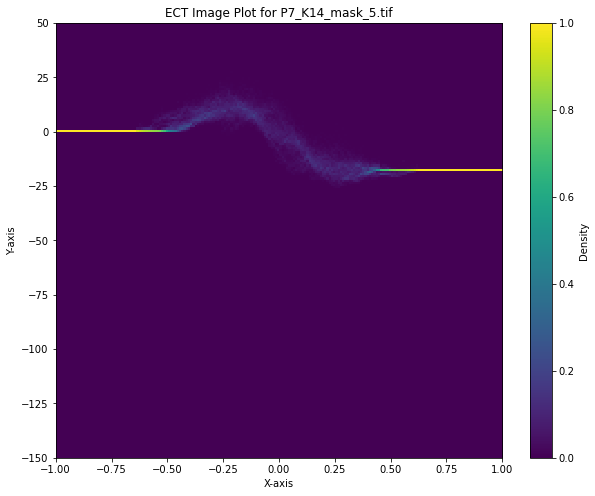

Computed ECT image for P7_K14_mask_1.tif


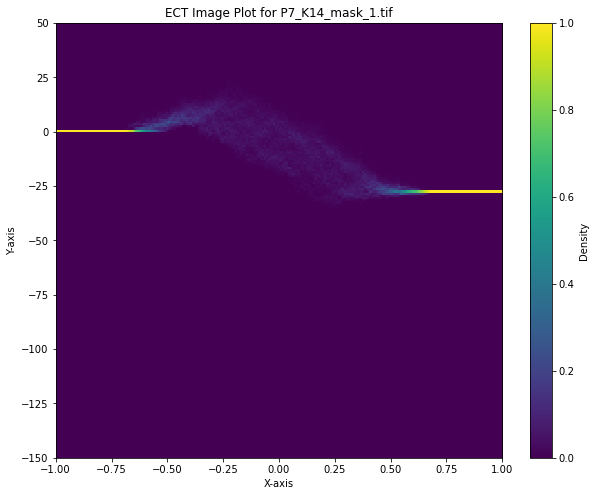

Computed ECT image for P7_K14_mask_7.tif


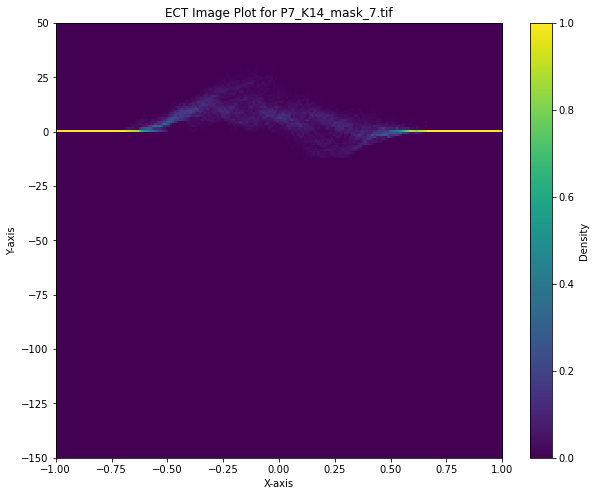

Computed ECT image for P7_K14_mask_2.tif


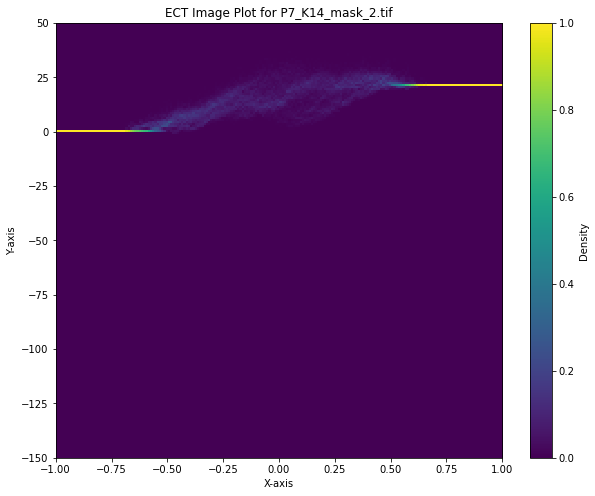

Computed ECT image for P7_K14_mask_6.tif


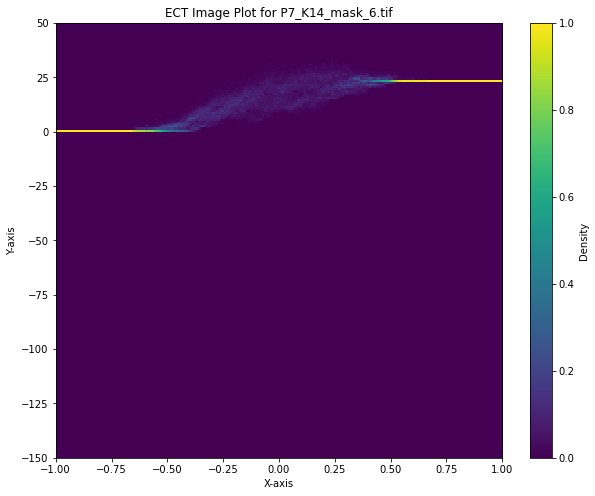

Computed ECT image for P7_K14_mask_3.tif


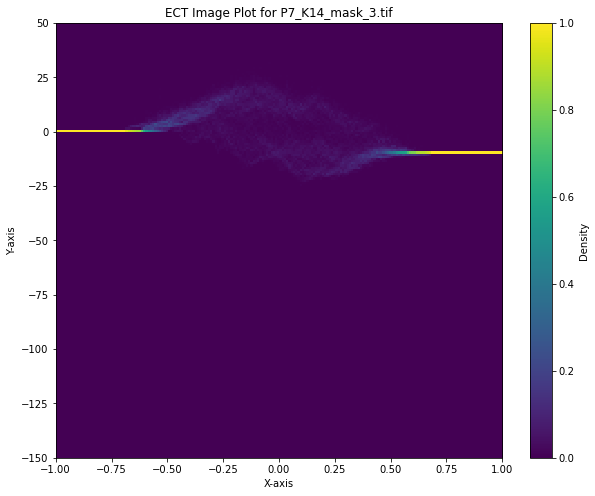

Computed ECT image for P7_K14_mask_4.tif


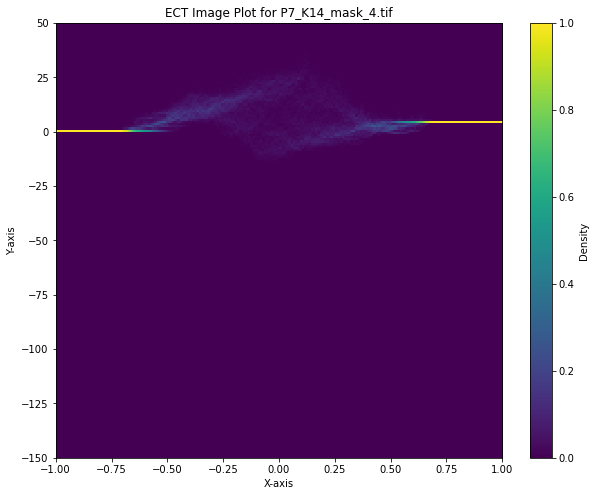

In [5]:
import os
import tifffile as tiff
import eucalc as ec
import matplotlib.colors as mcolors
from PIL import Image
class EctImg:
    def __init__(self, nm, img, k=20, xinterval=(-1., 1.), xpoints=100, yinterval=(-1., 1.), ypoints=100, factor=3):
        self.xinterval = xinterval
        self.yinterval = yinterval
        self.xpoints = xpoints
        self.ypoints = ypoints
        self.image = self.compute(img, k, xinterval, xpoints, yinterval, ypoints, factor)
        self.nm = nm
    def compute(self, img, k, xinterval, xpoints, yinterval, ypoints, factor):
        cplx = ec.EmbeddedComplex(img)
        cplx.preproc_ect()
        thetas = np.linspace(0, 2 * np.pi, k + 1)
        ect1 = np.empty((k, xpoints), dtype=float)
        for i in range(k):
            theta = thetas[i]
            direction = np.array((np.sin(theta), np.cos(theta)))
            ect_dir = cplx.compute_euler_characteristic_transform(direction)
            T = np.linspace(xinterval[0], xinterval[1], xpoints)
            ect1[i] = [ect_dir.evaluate(t) for t in T]

        image = np.zeros((ypoints, xpoints), dtype=float)
        yvalues = np.linspace(yinterval[0], yinterval[1], ypoints+1, endpoint=True)
        for i in range(xpoints):
            column = ect1[:, i]
            for j in range(ypoints):
                value = 0
                if j < ypoints-1:
                    value = len(np.where((yvalues[j] <= column) & (column < yvalues[j+1]))[0])/k
                else:
                    value = len(np.where((yvalues[j] <= column) & (column <= yvalues[j+1]))[0])/k
                image[j, i] = value
        return image
    
    def plot(self):
        plt.figure(figsize=(10, 8))
        # Using xinterval and yinterval directly in extent
        plt.imshow(self.image, aspect='auto', extent=[self.xinterval[0], self.xinterval[1], self.yinterval[0], self.yinterval[1]], origin='lower', interpolation='none')
        plt.colorbar(label='Density')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title('ECT Image Plot for '+ self.nm)
        plt.show()


def compute_ExIm(names, datafolder):
    ExImage = []
    
    for nm in names: 
        file_path = os.path.join(datafolder, nm)
        with Image.open(file_path) as img:
            img_array = np.array(img)
        
        # Now, compute the ECT image using the new array
        ect = EctImg(nm, img_array, k=480, xinterval=(-1, 1), xpoints=200, yinterval=(-150., 50.), ypoints=200, factor=3)
        print(f"Computed ECT image for {nm}")
        ect.plot()
        exim = ect.compute(img_array, k=480, xinterval=(-1, 1), xpoints=200, yinterval=(-150., 50.), ypoints=200, factor=3)
        ExImage.append(exim)

    return ExImage


def extract_age(name):
    return name.split('_')[0]

names_k14_Ad = [nm for nm in names_k14 if 'P7' == extract_age(nm)]
exim_k14_Ad = compute_ExIm(names_k14_Ad, datafolder)